In [1]:
import os
import librosa
# import pydub
from pydub import AudioSegment
import numpy as np
import copy
import random
from scipy import signal as scipy_signal
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import datetime

from torch.utils.tensorboard import SummaryWriter

import threading
import time

from tqdm.notebook import tqdm

In [2]:
dataset_dir = '/home/torooc/dataHDD2/speech_commands_v0.01/'

run_name = 'runs/visualization_test' + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)


In [3]:
testing_list_path = dataset_dir + 'testing_list.txt'
validation_list_path = dataset_dir + 'validation_list.txt'

In [4]:
with open(testing_list_path) as f:
    testing_list = f.readlines()
    testing_list = [file.strip() for file in testing_list]
    
with open(validation_list_path) as f:
    validation_list = f.readlines()
    validation_list = [file.strip() for file in validation_list]

In [5]:
command_dirs = os.listdir(dataset_dir)

command_dirs = [direc for direc in command_dirs if os.path.isdir(os.path.join(dataset_dir, direc))]

command_dirs.sort()

command_dirs.remove('_background_noise_')

In [6]:
print(command_dirs)

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


In [7]:
key2label_dict = dict()
label2key_list = list()

key2label_dict[' '] = 0
label2key_list.append(' ')

for i, command in enumerate(command_dirs):
    key2label_dict[command] = i + 1
    label2key_list.append(command)

In [8]:
key2label_dict

{' ': 0,
 'bed': 1,
 'bird': 2,
 'cat': 3,
 'dog': 4,
 'down': 5,
 'eight': 6,
 'five': 7,
 'four': 8,
 'go': 9,
 'happy': 10,
 'house': 11,
 'left': 12,
 'marvin': 13,
 'nine': 14,
 'no': 15,
 'off': 16,
 'on': 17,
 'one': 18,
 'right': 19,
 'seven': 20,
 'sheila': 21,
 'six': 22,
 'stop': 23,
 'three': 24,
 'tree': 25,
 'two': 26,
 'up': 27,
 'wow': 28,
 'yes': 29,
 'zero': 30}

In [9]:
total_wav_file_list = list()

for command_dir in command_dirs:
    wav_list = os.listdir(os.path.join(dataset_dir, command_dir))
    
    wav_list_with_prefix = [os.path.join(command_dir, file_name) for file_name in wav_list]
    
    total_wav_file_list += wav_list_with_prefix

In [10]:
training_list = list(set(total_wav_file_list) - set(testing_list) - set(validation_list))
training_list.sort()


In [11]:
'''
validation_list
testing_list
training_list
'''

'\nvalidation_list\ntesting_list\ntraining_list\n'

In [12]:
audio_metadata = list()

for wav_file_name in tqdm(total_wav_file_list):
    audio = AudioSegment.from_wav(dataset_dir + wav_file_name)
    fs = audio.frame_rate
    length_in_samples = audio.frame_count()
    
#   normalized_audio_array = np.asarray(audio.get_array_of_samples()) / 2 ** 15
    
#   print("Max: {}, Min: {}".format(max(normalized_audio_array), min(normalized_audio_array)))
    
    audio_metadata.append([fs, length_in_samples])

In [13]:
SR = 16000

class DatasetLoader():
    
    def __init__(self, batch_size, dataset_dir, wav_file_name_list, key2label, label2key, is_train):
        self.batch_size = batch_size
        self.dataset_dir = dataset_dir
        self.wav_file_name_list = copy.deepcopy(wav_file_name_list)
        self.sr = SR
        self.nsc_in_ms = 40
#         self.nov_in_ms = self.nsc_in_ms / 2
        self.nov_in_ms = 0
        self.nsc_in_sample = int(self.nsc_in_ms / 1000 * self.sr)
        self.nov_in_sample = int(self.nov_in_ms / 1000 * self.sr)
        
        self.key2label = key2label
        self.label2key = label2key
        
        self.spectrogram_list = list()
        self.label_list = list()
        
        self.lock = threading.RLock()
        
        self.num_thread = 4
        
        self.loading_counter = 0
        
        self.dataset_number = len(self.wav_file_name_list)
        
        self.is_train = is_train
        
    def shuffle_dataset_order(self):
        random.shuffle(self.wav_file_name_list)
        
    def load_dataset(self):
        
        self.shuffle_dataset_order()
        self.spectrogram_list = list()
        self.label_list = list()
        self.loading_counter = 0
        
        step = int(np.floor(self.dataset_number / self.num_thread))
        
        for i in range(self.num_thread):
            
            wav_file_name_list_thread = self.wav_file_name_list[i*step:(i+1)*step]
            
            if i + 1 == self.num_thread:
                wav_file_name_list_thread = self.wav_file_name_list[i*step:]
            
            thread = threading.Thread(target=self.load_spectrogram, args=(wav_file_name_list_thread,))
            thread.start()
        
    def batch_generator(self):
        
        self.load_dataset()
        x = 0
        
        while self.loading_counter < self.dataset_number or len(self.spectrogram_list) > self.batch_size:
            
            if len(self.spectrogram_list) >= self.batch_size:

                spectrogram_list = self.spectrogram_list[:self.batch_size]
                label_list = self.label_list[:self.batch_size]

                with self.lock:
                    self.spectrogram_list = self.spectrogram_list[self.batch_size:]
                    self.label_list = self.label_list[self.batch_size:]
#                     print('[GPU Count: {}]'.format(x))
#                     x += 1

                spectrogram_time_step_list = [specgram.shape[1] for specgram in spectrogram_list]
                max_time_step = max(spectrogram_time_step_list)
                freq_size = spectrogram_list[0].shape[0]
                batch = np.zeros([len(spectrogram_list), freq_size, max_time_step])

                for j, specgram in enumerate(spectrogram_list):
                    batch[j, :specgram.shape[0], :specgram.shape[1]] = specgram

                batch_label = np.asarray(label_list)

                yield batch, batch_label
            
            else:
                time.sleep(0.05)
        
        
        if len(self.spectrogram_list) > 0:

            spectrogram_list = self.spectrogram_list
            label_list = self.label_list

            with self.lock:
                self.spectrogram_list = self.spectrogram_list[self.batch_size:]
                self.label_list = self.label_list[self.batch_size:]
#                 print('[GPU Count: {}]'.format(x))
#                 x += 1

            spectrogram_time_step_list = [specgram.shape[1] for specgram in spectrogram_list]
            max_time_step = max(spectrogram_time_step_list)
            freq_size = spectrogram_list[0].shape[0]
            batch = np.zeros([len(spectrogram_list), freq_size, max_time_step])

            for j, specgram in enumerate(spectrogram_list):
                batch[j, :specgram.shape[0], :specgram.shape[1]] = specgram

            batch_label = np.asarray(label_list)

            yield batch, batch_label
        
        return 0
    

    def load_spectrogram(self, wav_file_name_list_part):

        for i, wav_file_name in enumerate(wav_file_name_list_part):

            audio = AudioSegment.from_wav(self.dataset_dir + wav_file_name)

            normalized_audio_array = np.asarray(audio.get_array_of_samples()) / 2 ** 15

            f, t, Zxx = scipy_signal.stft(normalized_audio_array, fs=self.sr, 
                                          nperseg=self.nsc_in_sample,
                                          noverlap=self.nov_in_sample)

            Sxx = np.abs(Zxx)

            normalized_spectrogram = (20 * np.log10(np.maximum(Sxx, 1e-8)) + 160) / 160
            
            ###
            if self.is_train:
                normalized_spectrogram += (np.random.random(normalized_spectrogram.shape) - 0.5)/10
                normalized_spectrogram = np.clip(normalized_spectrogram, 0, None)

            ###
            
            keyword = wav_file_name.split('/')[0]
            label = self.key2label[keyword]
            
            with self.lock:
                self.spectrogram_list.append(normalized_spectrogram)
                self.label_list.append(label)
                self.loading_counter += 1
#                 print('[Dataset Count: {}] [Specgram Length: {}]'.format(self.loading_counter, len(self.spectrogram_list)))
            

In [14]:
len(training_list)

51088

In [15]:
dataset_loader_training = DatasetLoader(768, dataset_dir, training_list, key2label_dict, label2key_list, True)
dataset_loader_testing = DatasetLoader(768, dataset_dir, testing_list, key2label_dict, label2key_list, False)
dataset_loader_validation = DatasetLoader(768, dataset_dir, validation_list, key2label_dict, label2key_list, False)

# dataset_loader_testing = DatasetLoader(64, dataset_dir, testing_list, key2label_dict, label2key_list)
# dataset_loader_validation = DatasetLoader(64, dataset_dir, validation_list, key2label_dict, label2key_list)

# dataset_loader_training = DatasetLoader(512, dataset_dir, training_list, key2label_dict, label2key_list)
# dataset_loader_testing = DatasetLoader(512, dataset_dir, testing_list, key2label_dict, label2key_list)
# dataset_loader_validation = DatasetLoader(512, dataset_dir, validation_list, key2label_dict, label2key_list)

# dataset_loader_training = DatasetLoader(768, dataset_dir, training_list, key2label_dict, label2key_list, True)
# dataset_loader_testing = DatasetLoader(768, dataset_dir, testing_list, key2label_dict, label2key_list, False)
# dataset_loader_validation = DatasetLoader(768, dataset_dir, validation_list, key2label_dict, label2key_list, False)

In [16]:
# batch_generator = dataset_loader_training.batch_generator()

In [17]:
# class basic_model(nn.Module):
#     def __init__(self, D_in, H, num_layers, num_labels):
#         super(basic_model, self).__init__()
#         self.fc = torch.nn.Linear(D_in, H)
#         self.relu = torch.nn.ReLU()
#         self.dropout = nn.Dropout(p=0.2)

#         self.gru_layers = nn.ModuleList([nn.GRU(H, int(H / 2), bidirectional=True, batch_first=True) for i in range(num_layers)])

#         self.fc_pred = nn.Linear(H, num_labels)
#         self.log_softmax = nn.LogSoftmax(dim=2)
        
#     def forward(self, input_tensor):
#         # (B, T, F)
#         output_tensor = self.fc(input_tensor)
#         output_tensor = self.relu(output_tensor)
#         output_tensor = self.dropout(output_tensor)
#         # (B, T, H)
#         for layer in self.gru_layers:
#             output_tensor, _ = layer(output_tensor)
            
#         output_tensor = self.fc_pred(output_tensor)

#         output_tensor = self.log_softmax(output_tensor)
        
#         return output_tensor

class basic_conv_model(nn.Module):
#     def __init__(self, first_kernel_size, second_kernel_size, dropout_rate, num_labels):
    def __init__(self):
        super(basic_conv_model, self).__init__()
        self.conv2d_1 = nn.Conv2d(1, 16, (13, 2))
        self.conv2d_2 = nn.Conv2d(16, 32, (13, 2))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(4800, 31)
        
    def forward(self, input_tensor):
        input_tensor.unsqueeze_(1)
        tensor = self.conv2d_1(input_tensor)
#         print('[After 1st Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.1, training=True)
        tensor = F.max_pool2d(tensor, (3, 2))
#         print('[After 1st maxpool2d]: {}'.format(tensor.shape))
        tensor = self.conv2d_2(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.1, training=True)
        tensor = F.max_pool2d(tensor, (3, 2))
#         print('[After 2nd maxpool2d]: {}'.format(tensor.shape))
        tensor = self.flatten(tensor)
#         print('[After Flatten]: {}'.format(tensor.shape))
        tensor = self.fc(tensor)
#         print('[After fc]: {}'.format(tensor.shape))
        pred_tensor = F.log_softmax(tensor, dim=-1)
        
        return pred_tensor
    
class basic_crnn_model(nn.Module):
#     def __init__(self, first_kernel_size, second_kernel_size, dropout_rate, num_labels):
    def __init__(self):
        super(basic_crnn_model, self).__init__()
#         self.conv2d = nn.Conv2d(1, 128, (13, 2))
        self.conv2d_1 = nn.Conv2d(1, 64, (7, 2))
        self.conv2d_2 = nn.Conv2d(64, 64, (7, 2))
#         self.gru_1 = nn.GRU(16 * 103, 256, 1)
#         self.gru_1 = nn.GRU(128 * 103, 256, 1, bidirectional=True)
#         self.gru_1 = nn.GRU(64 * 33, 256, 1, bidirectional=True)
#         self.gru_1 = nn.GRU(64 * 99, 256, 1, bidirectional=True)
        self.gru_1 = nn.GRU(19776, 256, 1, bidirectional=True)
        self.gru_2 = nn.GRU(512, 256, 1, bidirectional=True)
        self.gru_3 = nn.GRU(512, 256, 1, bidirectional=True)
        self.gru_4 = nn.GRU(512, 256, 1, bidirectional=True)
        self.flatten = nn.Flatten()
#         self.fc = nn.Linear(256 * 2 * 12, 31)
#         self.fc = nn.Linear(256 * 10, 31) # 5632
        self.fc = nn.Linear(256 * 48, 31) # 12288
#         self.fc = nn.Linear(256 * 22, 31)
        
    def forward(self, input_tensor):
        input_tensor.unsqueeze_(1)  # (B, 1, F, T)
        tensor = self.conv2d_1(input_tensor) # (B, 16, F, T)
#         print('[After 1st Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
#         tensor = F.dropout(tensor, 0.1, training=True)
#         tensor = F.max_pool2d(tensor, (3, 2))
#         print('[After 1st maxpool2d]: {}'.format(tensor.shape))

        tensor = self.conv2d_2(tensor) # (B, 16, F, T)
# #         print('[After 1st Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
#         tensor = F.dropout(tensor, 0.1, training=True)
#         tensor = F.max_pool2d(tensor, (3, 2))
        
        tensor = tensor.view(tensor.shape[0], -1, tensor.shape[3])
        # (B, 16 * F, T)
        
#         print('[After Reshape]: {}'.format(tensor.shape))
        
        tensor.transpose_(0, 2) # (T, F, B)
        tensor.transpose_(1, 2) # (T, B, F)

        tensor, _ = self.gru_1(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.2, training=True) # (T, B, F)
#         tensor = F.max_pool2d(tensor, (3, 2))
#         print('[After 2nd maxpool2d]: {}'.format(tensor.shape))

        tensor, _ = self.gru_2(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.2, training=True) # (T, B, F)
        
        tensor, _ = self.gru_3(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.2, training=True) # (T, B, F)
        
        tensor, _ = self.gru_4(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.2, training=True) # (T, B, F)

        tensor.transpose_(0, 1) # (B, T, F)
    
#         print('[After Reshape]: {}'.format(tensor.shape))
    
        tensor = self.flatten(tensor)
#         print('[After Flatten]: {}'.format(tensor.shape))
        tensor = self.fc(tensor)
#         print('[After fc]: {}'.format(tensor.shape))
        pred_tensor = F.log_softmax(tensor, dim=-1)
        
        return pred_tensor
    
class basic_rnn_model(nn.Module):
#     def __init__(self, first_kernel_size, second_kernel_size, dropout_rate, num_labels):
    def __init__(self):
        super(basic_rnn_model, self).__init__()
        self.gru_1 = nn.GRU(321, 128, 1, bidirectional=True)
        self.gru_2 = nn.GRU(256, 128, 1, bidirectional=True)
        self.gru_3 = nn.GRU(256, 128, 1, bidirectional=True)
        self.gru_4 = nn.GRU(256, 128, 1, bidirectional=True)
        self.gru_5 = nn.GRU(256, 128, 1, bidirectional=True)
        self.gru_6 = nn.GRU(256, 128, 1, bidirectional=True)
        self.gru_7 = nn.GRU(256, 128, 1, bidirectional=True)
        self.gru_8 = nn.GRU(256, 128, 1, bidirectional=True)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256 * 26, 31)
        
    def forward(self, input_tensor):
#       input_tensor.unsqueeze_(1)
        # (B, F, T)
        input_tensor.transpose_(0, 2) # (T, F, B)
        input_tensor.transpose_(1, 2) # (T, B, F)
        tensor, _ = self.gru_1(input_tensor)
#         print('[After 1st Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.2, training=True)
#         tensor = F.max_pool2d(tensor, (3, 2))
#         print('[After 1st maxpool2d]: {}'.format(tensor.shape))
        tensor, _ = self.gru_2(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.2, training=True)
#         tensor = F.max_pool2d(tensor, (3, 2))
#         print('[After 2nd maxpool2d]: {}'.format(tensor.shape))
        tensor, _ = self.gru_3(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.2, training=True)
        tensor, _ = self.gru_4(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.2, training=True)
        
        
        tensor, _ = self.gru_5(tensor)
#         print('[After 1st Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.2, training=True)
#         tensor = F.max_pool2d(tensor, (3, 2))
#         print('[After 1st maxpool2d]: {}'.format(tensor.shape))
        tensor, _ = self.gru_6(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.2, training=True)
#         tensor = F.max_pool2d(tensor, (3, 2))
#         print('[After 2nd maxpool2d]: {}'.format(tensor.shape))
        tensor, _ = self.gru_7(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.2, training=True)
        tensor, _ = self.gru_8(tensor)
#         print('[After 2nd Conv2d]: {}'.format(tensor.shape))
        tensor = F.relu(tensor)
        tensor = F.dropout(tensor, 0.2, training=True)
        
        tensor.transpose_(0, 1) # (B, T, F)
        tensor = self.flatten(tensor)
#         print('[After Flatten]: {}'.format(tensor.shape))
        tensor = self.fc(tensor)
#         print('[After fc]: {}'.format(tensor.shape))
        pred_tensor = F.log_softmax(tensor, dim=-1)
        
        return pred_tensor

    
# model = basic_model(321, 512, 3, 31).float().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# dictation_loss = nn.CTCLoss().to(device)

# model = basic_crnn_model().float().to(device)  
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
        

In [18]:
class hello_edge_fc_model(nn.Module):
    def __init__(self):
        super(hello_edge_fc_model, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(8346, 31)
        
    def forward(self, input_tensor):
        tensor = self.flatten(input_tensor)
        tensor = self.fc(tensor)
        pred_tensor = F.log_softmax(tensor, dim=-1)
        
        return pred_tensor
    
# model = basic_crnn_model().float().to(device)  
model = basic_rnn_model().float().to(device)  
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [19]:
# batch_generator = dataset_loader_training.batch_generator()
# next(batch_generator)[0].shape

18:12:45.854546
#000 [Train: 3.407] [Test: 3.392] [Valid: 3.391]
#000 [Train: 0.037] [Test: 0.042] [Valid: 0.040]


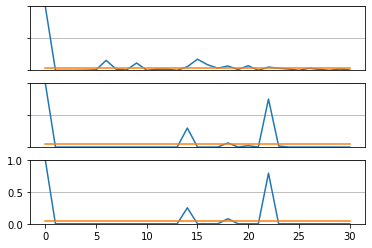

18:13:14.230573
#001 [Train: 3.214] [Test: 3.004] [Valid: 2.953]
#001 [Train: 0.085] [Test: 0.111] [Valid: 0.123]


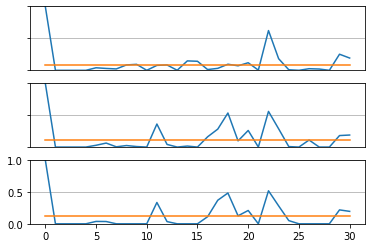

18:13:42.607335
#002 [Train: 2.940] [Test: 2.887] [Valid: 2.828]
#002 [Train: 0.129] [Test: 0.131] [Valid: 0.150]


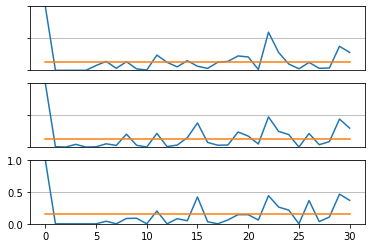

18:14:11.028641
#003 [Train: 2.810] [Test: 2.746] [Valid: 2.689]
#003 [Train: 0.152] [Test: 0.165] [Valid: 0.188]


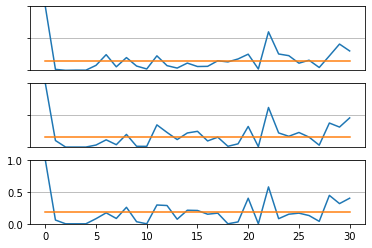

18:14:39.421072
#004 [Train: 2.696] [Test: 2.675] [Valid: 2.620]
#004 [Train: 0.180] [Test: 0.182] [Valid: 0.194]


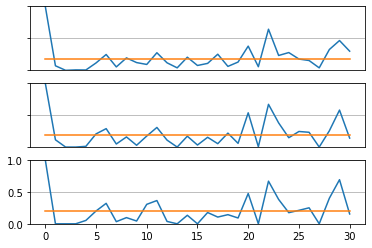

18:15:07.893922
#005 [Train: 2.565] [Test: 2.507] [Valid: 2.441]
#005 [Train: 0.214] [Test: 0.231] [Valid: 0.253]


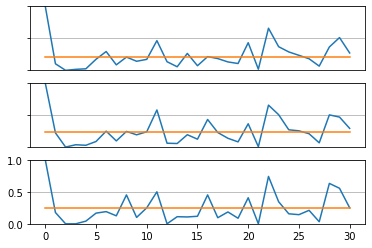

18:15:36.678528
#006 [Train: 2.420] [Test: 2.374] [Valid: 2.324]
#006 [Train: 0.251] [Test: 0.274] [Valid: 0.284]


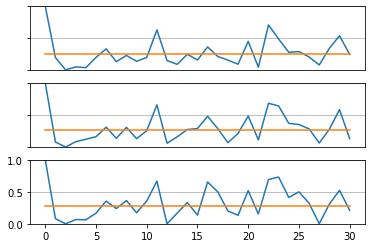

18:16:05.272614
#007 [Train: 2.284] [Test: 2.266] [Valid: 2.204]
#007 [Train: 0.290] [Test: 0.298] [Valid: 0.313]


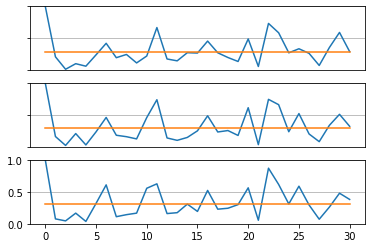

18:16:33.885559
#008 [Train: 2.178] [Test: 2.150] [Valid: 2.087]
#008 [Train: 0.324] [Test: 0.343] [Valid: 0.360]


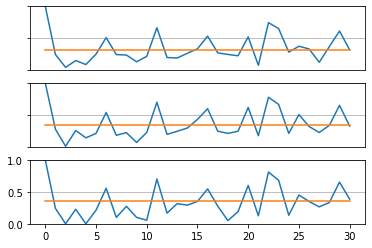

18:17:02.204900
#009 [Train: 2.042] [Test: 2.022] [Valid: 1.967]
#009 [Train: 0.362] [Test: 0.378] [Valid: 0.390]


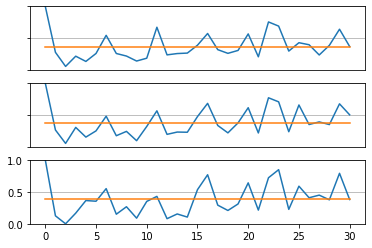

18:17:31.239604
#010 [Train: 1.926] [Test: 1.929] [Valid: 1.865]
#010 [Train: 0.401] [Test: 0.413] [Valid: 0.414]


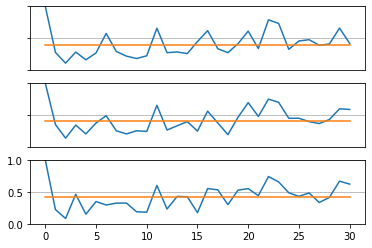

18:17:59.545597
#011 [Train: 1.822] [Test: 1.790] [Valid: 1.756]
#011 [Train: 0.430] [Test: 0.449] [Valid: 0.446]


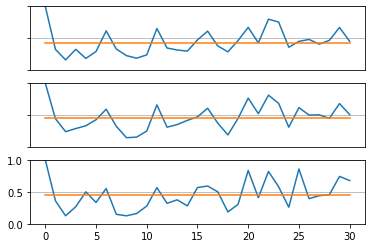

18:18:28.405694
#012 [Train: 1.717] [Test: 1.699] [Valid: 1.677]
#012 [Train: 0.461] [Test: 0.471] [Valid: 0.468]


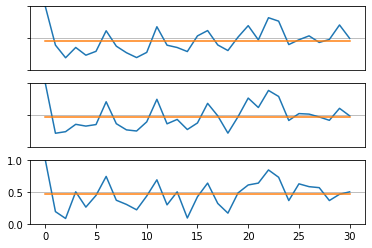

18:18:57.241739
#013 [Train: 1.628] [Test: 1.612] [Valid: 1.589]
#013 [Train: 0.486] [Test: 0.495] [Valid: 0.500]


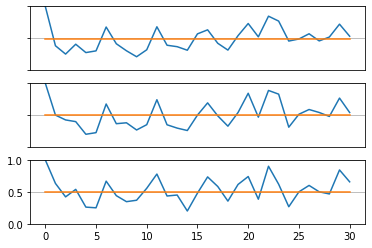

18:19:25.852394
#014 [Train: 1.553] [Test: 1.535] [Valid: 1.527]
#014 [Train: 0.509] [Test: 0.524] [Valid: 0.520]


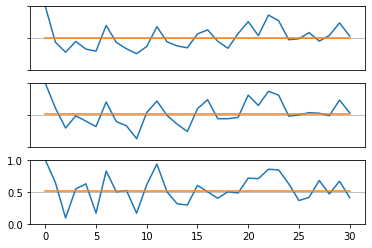

18:19:54.718732
#015 [Train: 1.462] [Test: 1.476] [Valid: 1.462]
#015 [Train: 0.538] [Test: 0.536] [Valid: 0.544]


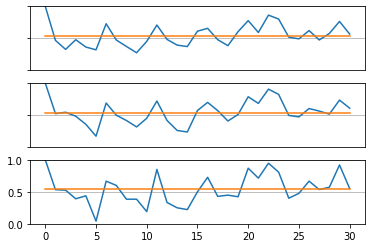

18:20:24.226373
#016 [Train: 1.410] [Test: 1.404] [Valid: 1.366]
#016 [Train: 0.558] [Test: 0.563] [Valid: 0.571]


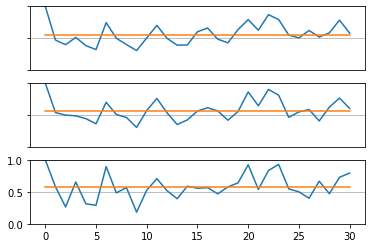

18:20:53.570150
#017 [Train: 1.324] [Test: 1.324] [Valid: 1.319]
#017 [Train: 0.582] [Test: 0.582] [Valid: 0.587]


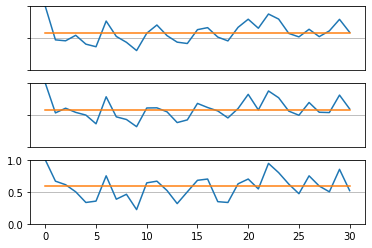

18:21:22.888396
#018 [Train: 1.253] [Test: 1.250] [Valid: 1.229]
#018 [Train: 0.606] [Test: 0.605] [Valid: 0.620]


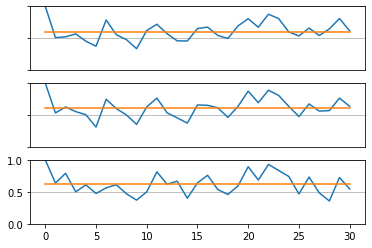

18:21:52.241166
#019 [Train: 1.198] [Test: 1.215] [Valid: 1.195]
#019 [Train: 0.624] [Test: 0.622] [Valid: 0.629]


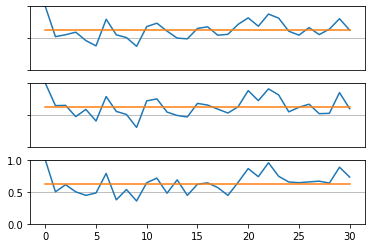

18:22:21.190562
#020 [Train: 1.140] [Test: 1.172] [Valid: 1.140]
#020 [Train: 0.643] [Test: 0.633] [Valid: 0.651]


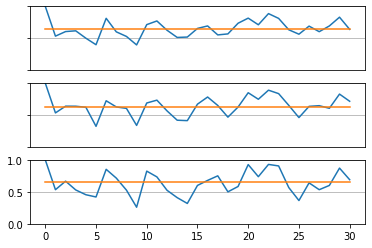

18:22:49.515190
#021 [Train: 1.096] [Test: 1.141] [Valid: 1.118]
#021 [Train: 0.655] [Test: 0.647] [Valid: 0.660]


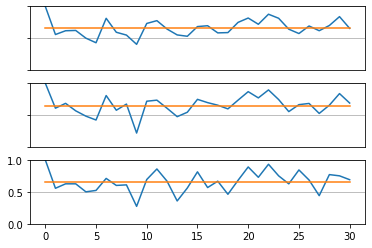

18:23:18.536877
#022 [Train: 1.043] [Test: 1.113] [Valid: 1.066]
#022 [Train: 0.676] [Test: 0.655] [Valid: 0.680]


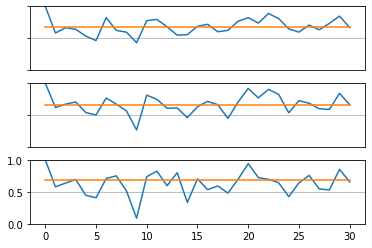

18:23:47.183853
#023 [Train: 1.008] [Test: 1.057] [Valid: 1.031]
#023 [Train: 0.685] [Test: 0.678] [Valid: 0.686]


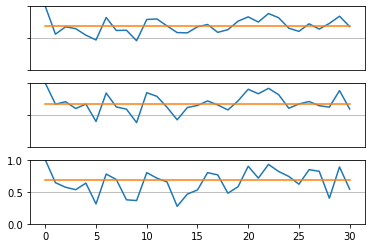

18:24:16.101998
#024 [Train: 0.964] [Test: 1.019] [Valid: 0.985]
#024 [Train: 0.703] [Test: 0.691] [Valid: 0.699]


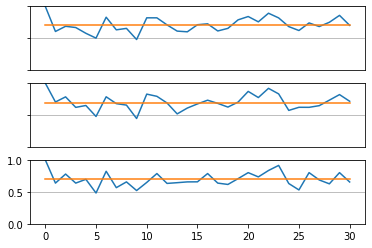

18:24:45.689821
#025 [Train: 0.933] [Test: 0.978] [Valid: 0.935]
#025 [Train: 0.710] [Test: 0.700] [Valid: 0.714]


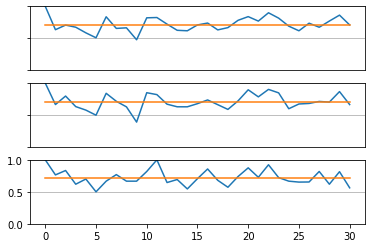

18:25:14.461322
#026 [Train: 0.897] [Test: 0.966] [Valid: 0.930]
#026 [Train: 0.720] [Test: 0.704] [Valid: 0.715]


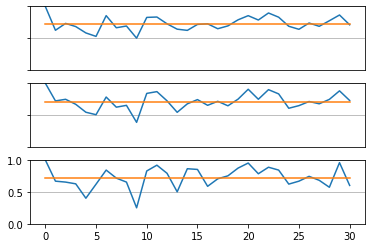

18:25:43.480366
#027 [Train: 0.870] [Test: 0.938] [Valid: 0.898]
#027 [Train: 0.730] [Test: 0.720] [Valid: 0.726]


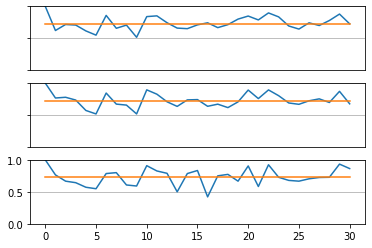

18:26:12.697018
#028 [Train: 0.848] [Test: 0.893] [Valid: 0.866]
#028 [Train: 0.736] [Test: 0.724] [Valid: 0.736]


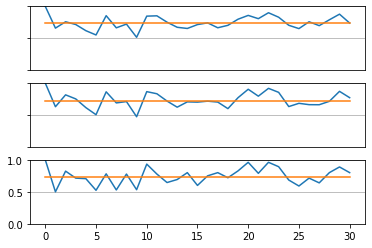

18:26:41.783466
#029 [Train: 0.813] [Test: 0.879] [Valid: 0.853]
#029 [Train: 0.747] [Test: 0.731] [Valid: 0.737]


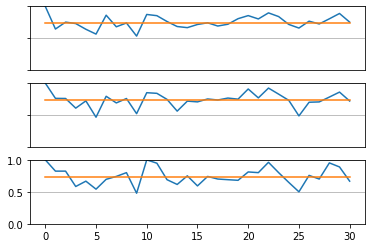

18:27:10.587177
#030 [Train: 0.791] [Test: 0.868] [Valid: 0.828]
#030 [Train: 0.755] [Test: 0.734] [Valid: 0.741]


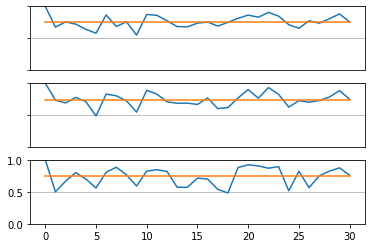

18:27:39.446517
#031 [Train: 0.769] [Test: 0.826] [Valid: 0.800]
#031 [Train: 0.761] [Test: 0.748] [Valid: 0.753]


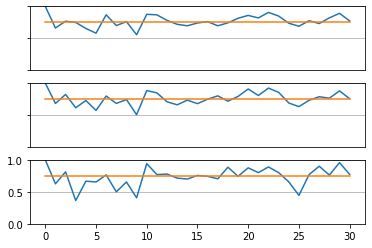

18:28:09.141007
#032 [Train: 0.746] [Test: 0.801] [Valid: 0.765]
#032 [Train: 0.769] [Test: 0.758] [Valid: 0.766]


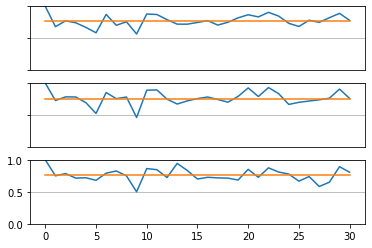

18:28:38.926633
#033 [Train: 0.719] [Test: 0.786] [Valid: 0.772]
#033 [Train: 0.777] [Test: 0.758] [Valid: 0.758]


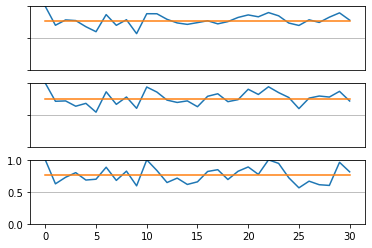

18:29:08.823473
#034 [Train: 0.699] [Test: 0.765] [Valid: 0.733]
#034 [Train: 0.784] [Test: 0.768] [Valid: 0.778]


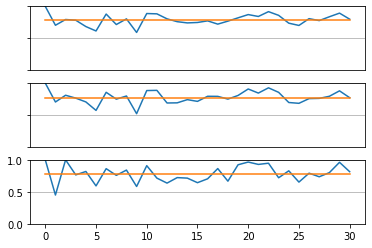

18:29:37.808768
#035 [Train: 0.678] [Test: 0.774] [Valid: 0.730]
#035 [Train: 0.789] [Test: 0.767] [Valid: 0.775]


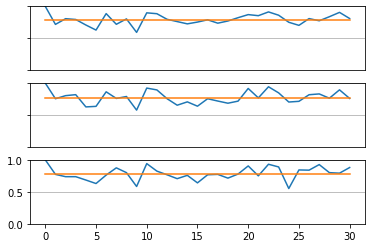

18:30:07.520614
#036 [Train: 0.672] [Test: 0.746] [Valid: 0.729]
#036 [Train: 0.793] [Test: 0.777] [Valid: 0.774]


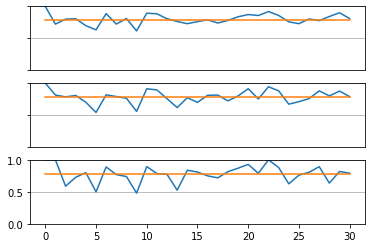

18:30:37.014747
#037 [Train: 0.648] [Test: 0.727] [Valid: 0.691]
#037 [Train: 0.798] [Test: 0.780] [Valid: 0.788]


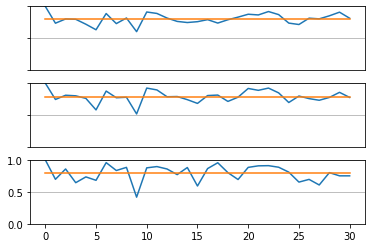

18:31:06.899933
#038 [Train: 0.629] [Test: 0.697] [Valid: 0.677]
#038 [Train: 0.805] [Test: 0.785] [Valid: 0.792]


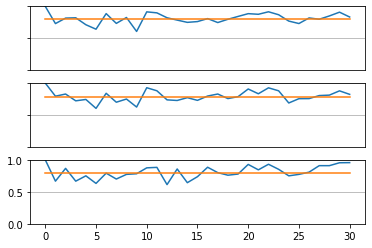

18:31:36.603980
#039 [Train: 0.619] [Test: 0.687] [Valid: 0.664]
#039 [Train: 0.807] [Test: 0.795] [Valid: 0.793]


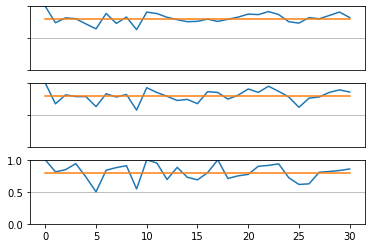

18:32:06.131113
#040 [Train: 0.601] [Test: 0.723] [Valid: 0.679]
#040 [Train: 0.815] [Test: 0.781] [Valid: 0.794]


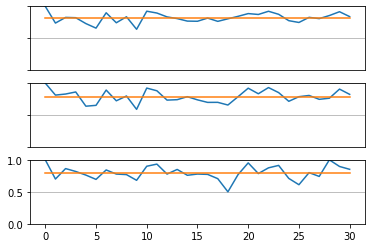

18:32:35.381636
#041 [Train: 0.590] [Test: 0.670] [Valid: 0.645]
#041 [Train: 0.818] [Test: 0.799] [Valid: 0.801]


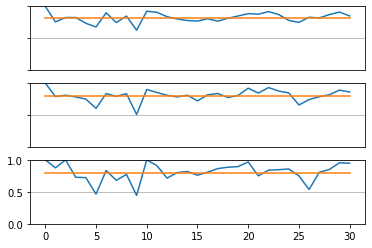

18:34:35.437108
#045 [Train: 0.542] [Test: 0.641] [Valid: 0.605]
#045 [Train: 0.833] [Test: 0.806] [Valid: 0.818]


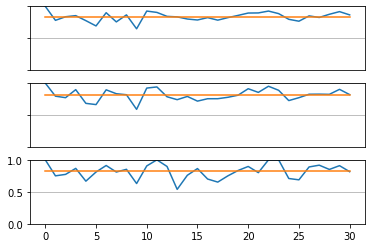

18:35:07.463713
#046 [Train: 0.532] [Test: 0.623] [Valid: 0.583]
#046 [Train: 0.835] [Test: 0.811] [Valid: 0.820]


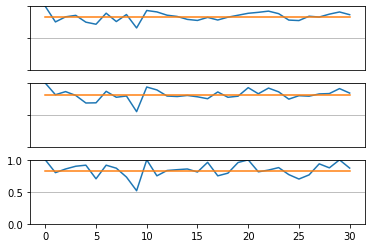

18:35:38.904161
#047 [Train: 0.523] [Test: 0.607] [Valid: 0.592]
#047 [Train: 0.839] [Test: 0.822] [Valid: 0.826]


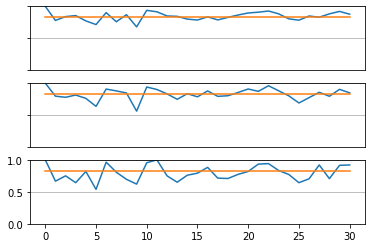

18:36:10.595666
#048 [Train: 0.507] [Test: 0.587] [Valid: 0.562]
#048 [Train: 0.843] [Test: 0.827] [Valid: 0.831]


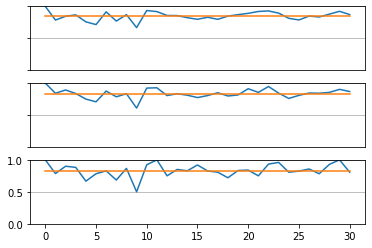

18:36:42.189772
#049 [Train: 0.502] [Test: 0.576] [Valid: 0.553]
#049 [Train: 0.846] [Test: 0.827] [Valid: 0.834]


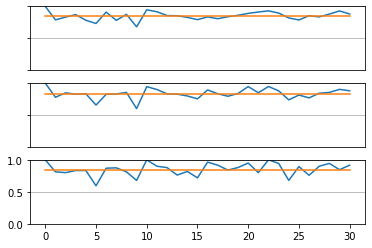

18:37:14.147385
#050 [Train: 0.485] [Test: 0.576] [Valid: 0.558]
#050 [Train: 0.851] [Test: 0.827] [Valid: 0.833]


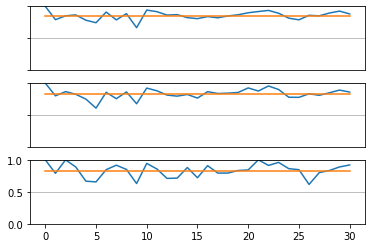

18:37:46.753072
#051 [Train: 0.484] [Test: 0.570] [Valid: 0.557]
#051 [Train: 0.850] [Test: 0.830] [Valid: 0.830]


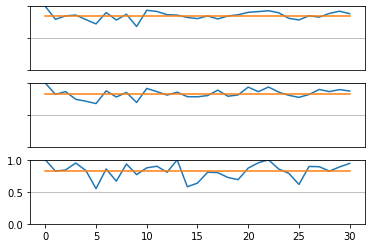

18:38:18.792021
#052 [Train: 0.479] [Test: 0.555] [Valid: 0.537]
#052 [Train: 0.853] [Test: 0.833] [Valid: 0.837]


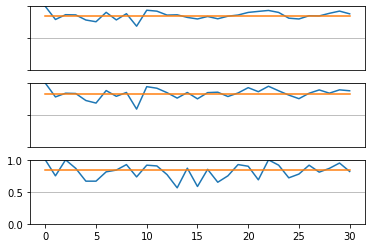

18:38:50.502929
#053 [Train: 0.464] [Test: 0.545] [Valid: 0.527]
#053 [Train: 0.855] [Test: 0.834] [Valid: 0.839]


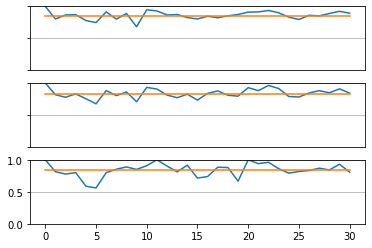

18:39:22.523310
#054 [Train: 0.457] [Test: 0.564] [Valid: 0.543]
#054 [Train: 0.859] [Test: 0.832] [Valid: 0.836]


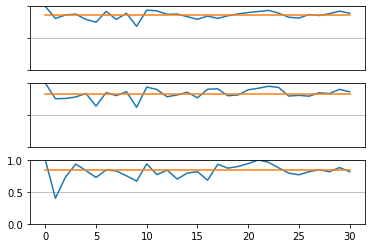

18:39:54.084896
#055 [Train: 0.447] [Test: 0.539] [Valid: 0.512]
#055 [Train: 0.862] [Test: 0.835] [Valid: 0.843]


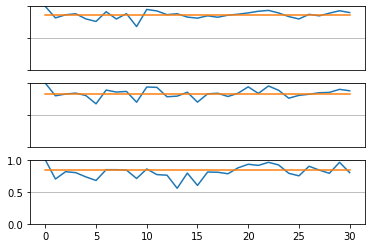

18:40:25.428014
#056 [Train: 0.441] [Test: 0.552] [Valid: 0.508]
#056 [Train: 0.864] [Test: 0.838] [Valid: 0.842]


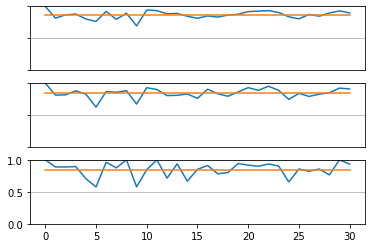

18:40:57.396845
#057 [Train: 0.437] [Test: 0.526] [Valid: 0.506]
#057 [Train: 0.867] [Test: 0.845] [Valid: 0.851]


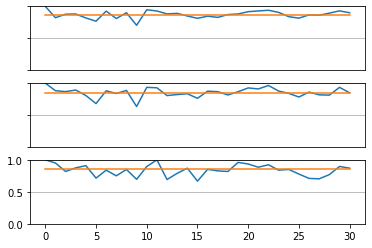

18:41:29.352887
#058 [Train: 0.423] [Test: 0.523] [Valid: 0.513]
#058 [Train: 0.870] [Test: 0.844] [Valid: 0.847]


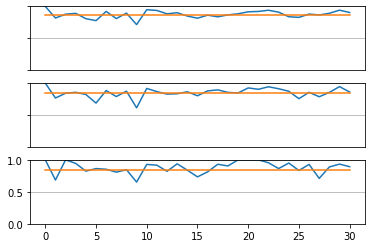

18:42:01.525119
#059 [Train: 0.416] [Test: 0.512] [Valid: 0.493]
#059 [Train: 0.872] [Test: 0.846] [Valid: 0.852]


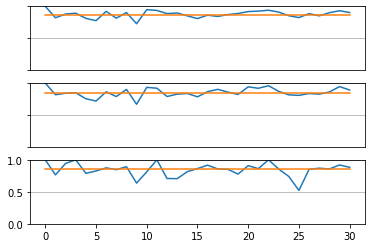

18:42:34.079005
#060 [Train: 0.413] [Test: 0.521] [Valid: 0.495]
#060 [Train: 0.874] [Test: 0.843] [Valid: 0.855]


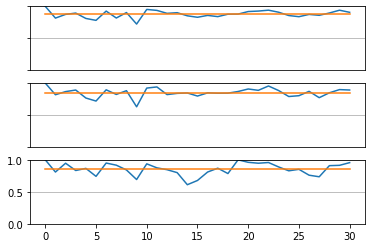

18:43:05.568325
#061 [Train: 0.406] [Test: 0.512] [Valid: 0.477]
#061 [Train: 0.874] [Test: 0.847] [Valid: 0.855]


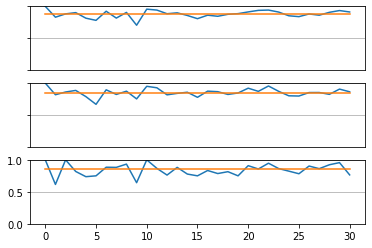

18:43:37.117923
#062 [Train: 0.402] [Test: 0.504] [Valid: 0.502]
#062 [Train: 0.875] [Test: 0.850] [Valid: 0.848]


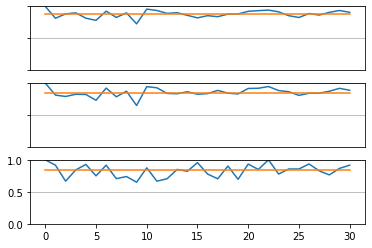

18:44:09.541195
#063 [Train: 0.398] [Test: 0.493] [Valid: 0.472]
#063 [Train: 0.876] [Test: 0.854] [Valid: 0.860]


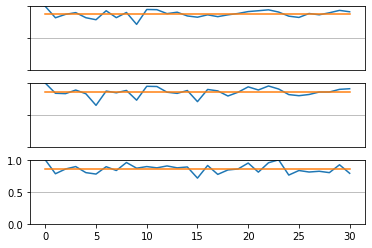

18:44:41.975212
#064 [Train: 0.390] [Test: 0.506] [Valid: 0.478]
#064 [Train: 0.879] [Test: 0.850] [Valid: 0.858]


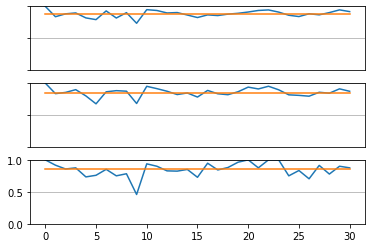

18:45:13.252246
#065 [Train: 0.388] [Test: 0.506] [Valid: 0.479]
#065 [Train: 0.879] [Test: 0.848] [Valid: 0.857]


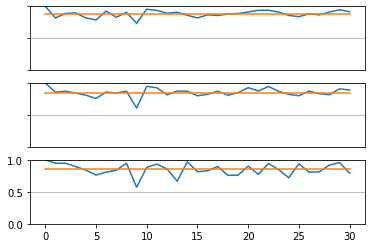

18:45:44.820009
#066 [Train: 0.374] [Test: 0.482] [Valid: 0.466]
#066 [Train: 0.883] [Test: 0.857] [Valid: 0.858]


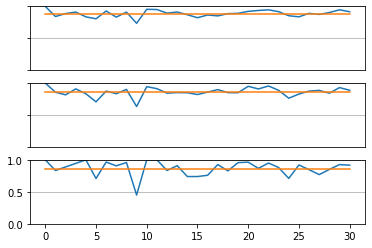

18:46:16.777208
#067 [Train: 0.373] [Test: 0.472] [Valid: 0.445]
#067 [Train: 0.884] [Test: 0.859] [Valid: 0.866]


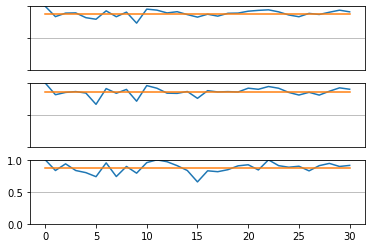

18:46:48.720000
#068 [Train: 0.363] [Test: 0.467] [Valid: 0.452]
#068 [Train: 0.886] [Test: 0.859] [Valid: 0.864]


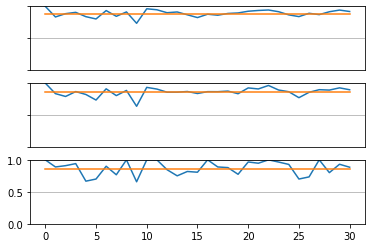

18:47:20.076912
#069 [Train: 0.363] [Test: 0.475] [Valid: 0.462]
#069 [Train: 0.888] [Test: 0.859] [Valid: 0.863]


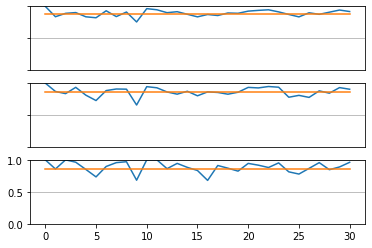

18:47:52.773194
#070 [Train: 0.356] [Test: 0.478] [Valid: 0.448]
#070 [Train: 0.890] [Test: 0.859] [Valid: 0.867]


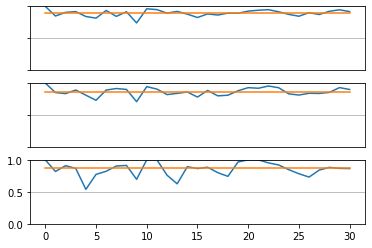

18:48:24.580889
#071 [Train: 0.351] [Test: 0.466] [Valid: 0.460]
#071 [Train: 0.891] [Test: 0.858] [Valid: 0.859]


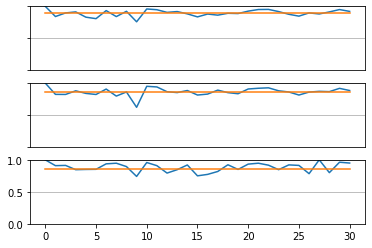

18:48:56.219481
#072 [Train: 0.347] [Test: 0.471] [Valid: 0.466]
#072 [Train: 0.892] [Test: 0.855] [Valid: 0.860]


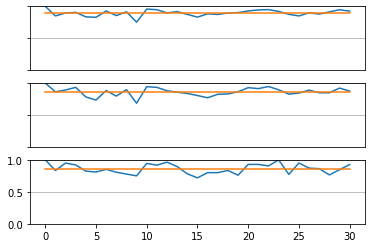

18:49:27.517347
#073 [Train: 0.342] [Test: 0.443] [Valid: 0.444]
#073 [Train: 0.894] [Test: 0.869] [Valid: 0.864]


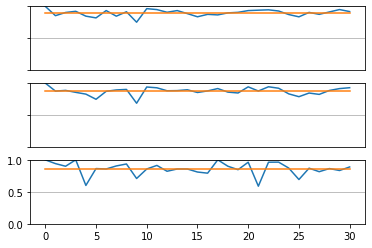

18:49:57.962662
#074 [Train: 0.335] [Test: 0.478] [Valid: 0.449]
#074 [Train: 0.896] [Test: 0.857] [Valid: 0.863]


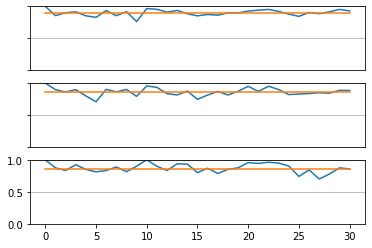

18:50:28.047703
#075 [Train: 0.331] [Test: 0.455] [Valid: 0.431]
#075 [Train: 0.896] [Test: 0.866] [Valid: 0.872]


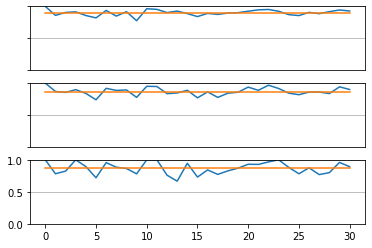

18:50:58.519745
#076 [Train: 0.328] [Test: 0.451] [Valid: 0.439]
#076 [Train: 0.898] [Test: 0.865] [Valid: 0.868]


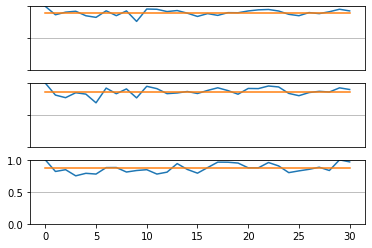

18:51:28.194143
#077 [Train: 0.323] [Test: 0.439] [Valid: 0.432]
#077 [Train: 0.899] [Test: 0.869] [Valid: 0.873]


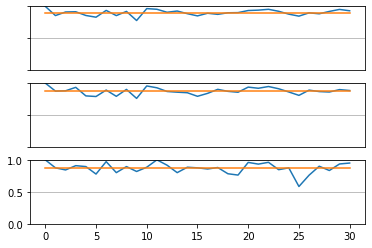

18:51:57.730750
#078 [Train: 0.321] [Test: 0.474] [Valid: 0.443]
#078 [Train: 0.900] [Test: 0.860] [Valid: 0.869]


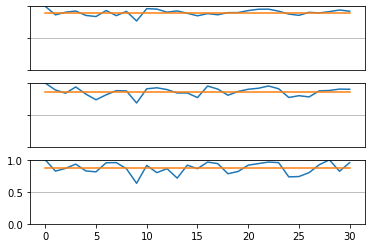

18:52:27.349661
#079 [Train: 0.321] [Test: 0.448] [Valid: 0.441]
#079 [Train: 0.899] [Test: 0.870] [Valid: 0.869]


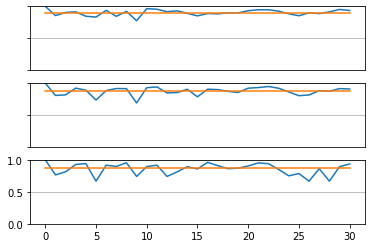

18:52:56.654420
#080 [Train: 0.315] [Test: 0.434] [Valid: 0.428]
#080 [Train: 0.904] [Test: 0.872] [Valid: 0.877]


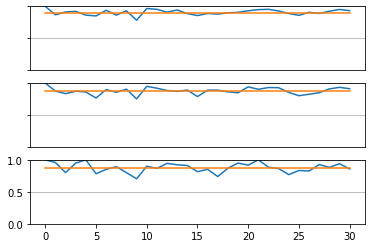

18:53:26.909520
#081 [Train: 0.308] [Test: 0.436] [Valid: 0.412]
#081 [Train: 0.903] [Test: 0.874] [Valid: 0.874]


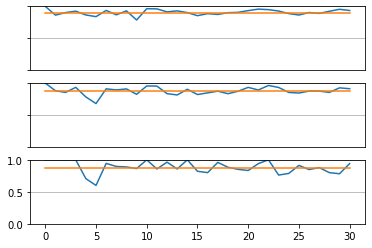

18:53:57.267495
#082 [Train: 0.299] [Test: 0.410] [Valid: 0.413]
#082 [Train: 0.906] [Test: 0.878] [Valid: 0.876]


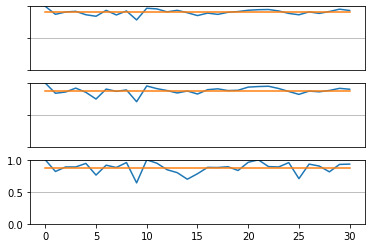

18:54:27.600998
#083 [Train: 0.302] [Test: 0.416] [Valid: 0.409]
#083 [Train: 0.906] [Test: 0.878] [Valid: 0.880]


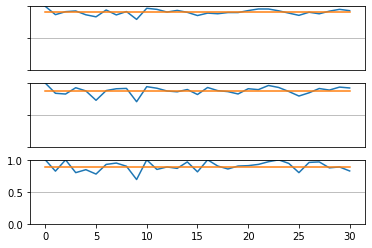

18:54:56.883105
#084 [Train: 0.299] [Test: 0.425] [Valid: 0.415]
#084 [Train: 0.906] [Test: 0.872] [Valid: 0.876]


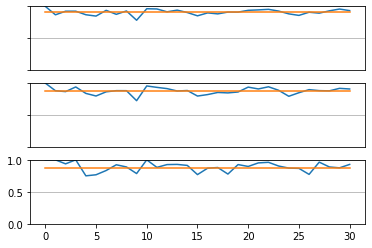

18:55:25.862170
#085 [Train: 0.291] [Test: 0.414] [Valid: 0.414]
#085 [Train: 0.909] [Test: 0.880] [Valid: 0.877]


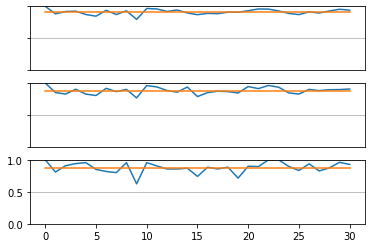

18:55:55.883351
#086 [Train: 0.286] [Test: 0.433] [Valid: 0.408]
#086 [Train: 0.910] [Test: 0.875] [Valid: 0.879]


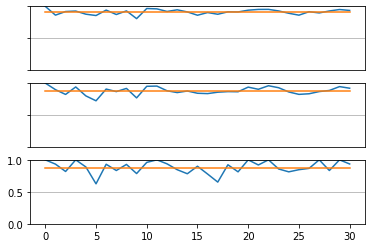

18:56:26.964107
#087 [Train: 0.285] [Test: 0.424] [Valid: 0.406]
#087 [Train: 0.911] [Test: 0.875] [Valid: 0.879]


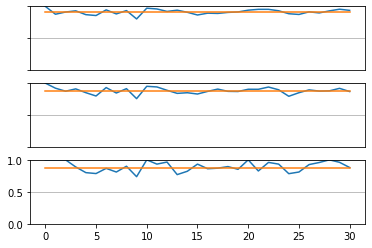

18:56:56.316413
#088 [Train: 0.280] [Test: 0.407] [Valid: 0.396]
#088 [Train: 0.912] [Test: 0.879] [Valid: 0.880]


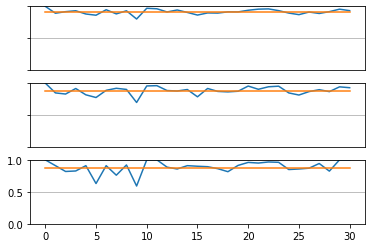

18:57:26.411397
#089 [Train: 0.282] [Test: 0.409] [Valid: 0.396]
#089 [Train: 0.912] [Test: 0.880] [Valid: 0.882]


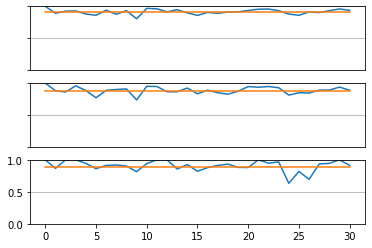

18:57:56.290817
#090 [Train: 0.276] [Test: 0.399] [Valid: 0.399]
#090 [Train: 0.914] [Test: 0.882] [Valid: 0.883]


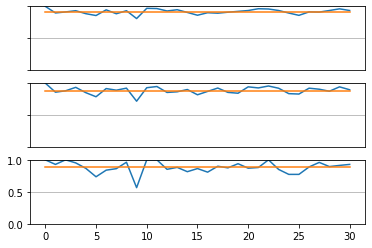

18:58:29.721414
#091 [Train: 0.272] [Test: 0.399] [Valid: 0.394]
#091 [Train: 0.915] [Test: 0.887] [Valid: 0.882]


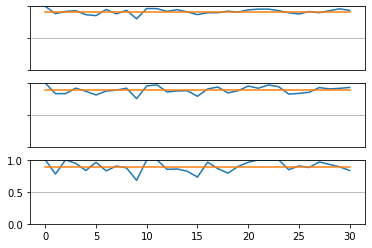

18:59:02.681822
#092 [Train: 0.273] [Test: 0.408] [Valid: 0.392]
#092 [Train: 0.915] [Test: 0.881] [Valid: 0.886]


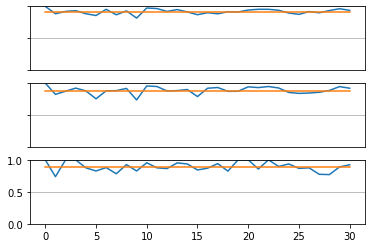

18:59:35.784613
#093 [Train: 0.266] [Test: 0.410] [Valid: 0.380]
#093 [Train: 0.917] [Test: 0.879] [Valid: 0.884]


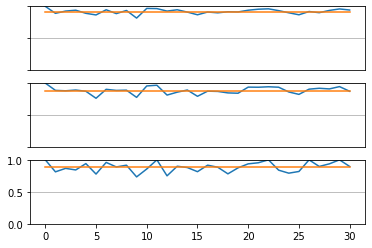

19:00:09.054922
#094 [Train: 0.266] [Test: 0.391] [Valid: 0.382]
#094 [Train: 0.917] [Test: 0.885] [Valid: 0.887]


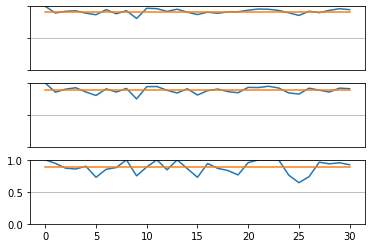

19:00:41.987325
#095 [Train: 0.269] [Test: 0.391] [Valid: 0.397]
#095 [Train: 0.917] [Test: 0.886] [Valid: 0.883]


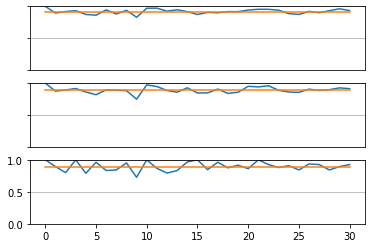

19:01:13.090986
#096 [Train: 0.256] [Test: 0.388] [Valid: 0.383]
#096 [Train: 0.919] [Test: 0.885] [Valid: 0.888]


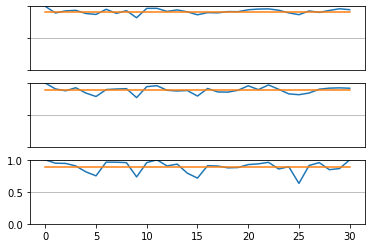

19:01:44.011109
#097 [Train: 0.257] [Test: 0.399] [Valid: 0.386]
#097 [Train: 0.919] [Test: 0.883] [Valid: 0.888]


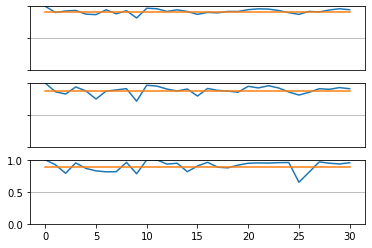

19:02:15.181793
#098 [Train: 0.254] [Test: 0.384] [Valid: 0.383]
#098 [Train: 0.920] [Test: 0.887] [Valid: 0.883]


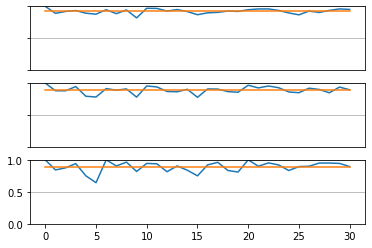

19:02:45.952928
#099 [Train: 0.249] [Test: 0.384] [Valid: 0.386]
#099 [Train: 0.922] [Test: 0.889] [Valid: 0.884]


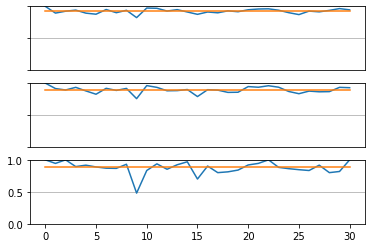

19:03:16.475793
#100 [Train: 0.248] [Test: 0.379] [Valid: 0.372]
#100 [Train: 0.923] [Test: 0.890] [Valid: 0.889]


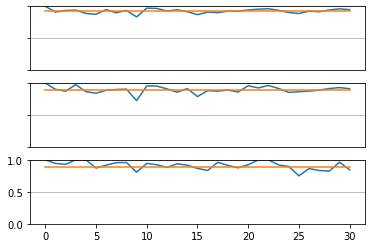

19:03:47.244729
#101 [Train: 0.242] [Test: 0.380] [Valid: 0.379]
#101 [Train: 0.924] [Test: 0.892] [Valid: 0.894]


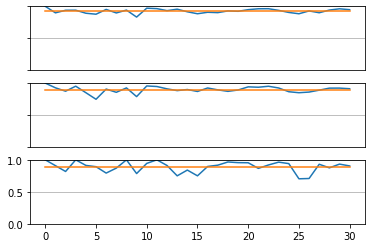

19:04:18.971870
#102 [Train: 0.243] [Test: 0.366] [Valid: 0.369]
#102 [Train: 0.924] [Test: 0.892] [Valid: 0.895]


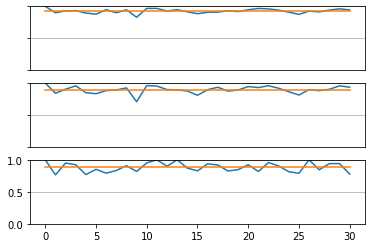

19:04:49.968061
#103 [Train: 0.238] [Test: 0.380] [Valid: 0.381]
#103 [Train: 0.925] [Test: 0.886] [Valid: 0.889]


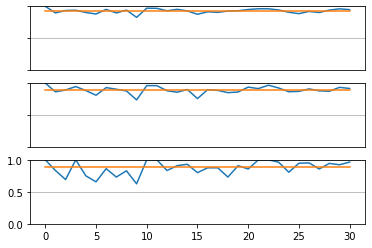

19:05:22.031883
#104 [Train: 0.240] [Test: 0.374] [Valid: 0.366]
#104 [Train: 0.926] [Test: 0.893] [Valid: 0.896]


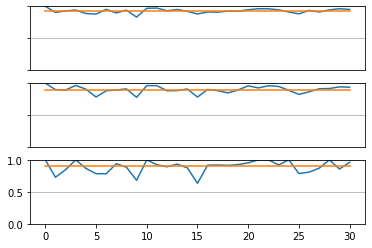

19:05:54.035806
#105 [Train: 0.234] [Test: 0.394] [Valid: 0.391]
#105 [Train: 0.927] [Test: 0.888] [Valid: 0.887]


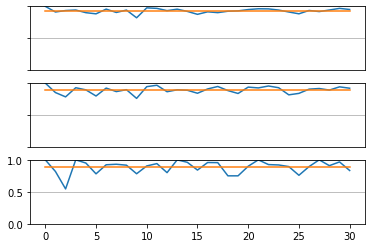

19:06:25.823552
#106 [Train: 0.230] [Test: 0.374] [Valid: 0.371]
#106 [Train: 0.928] [Test: 0.892] [Valid: 0.891]


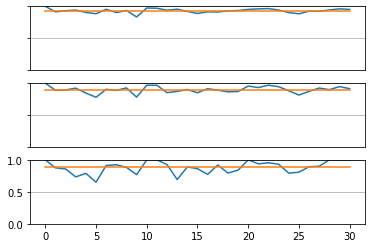

19:06:58.176300
#107 [Train: 0.229] [Test: 0.377] [Valid: 0.365]
#107 [Train: 0.929] [Test: 0.892] [Valid: 0.896]


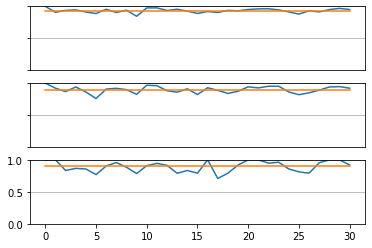

19:07:30.246461
#108 [Train: 0.231] [Test: 0.392] [Valid: 0.377]
#108 [Train: 0.927] [Test: 0.884] [Valid: 0.892]


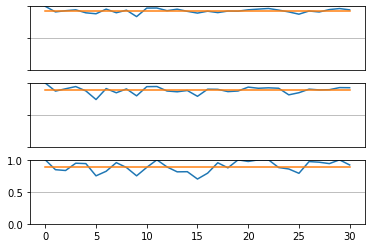

19:08:01.672255
#109 [Train: 0.226] [Test: 0.369] [Valid: 0.364]
#109 [Train: 0.930] [Test: 0.894] [Valid: 0.893]


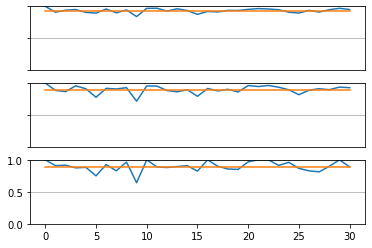

19:08:34.152278
#110 [Train: 0.220] [Test: 0.372] [Valid: 0.353]
#110 [Train: 0.932] [Test: 0.895] [Valid: 0.897]


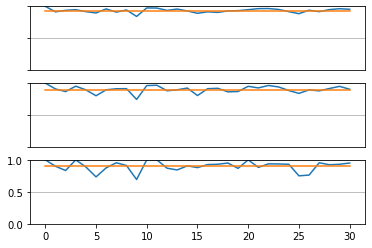

19:09:05.593192
#111 [Train: 0.221] [Test: 0.366] [Valid: 0.364]
#111 [Train: 0.930] [Test: 0.893] [Valid: 0.892]


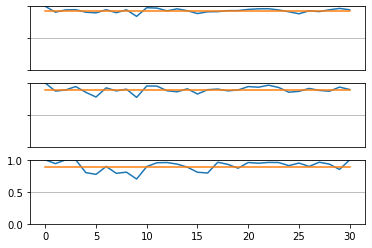

19:09:36.755842
#112 [Train: 0.219] [Test: 0.363] [Valid: 0.363]
#112 [Train: 0.931] [Test: 0.896] [Valid: 0.897]


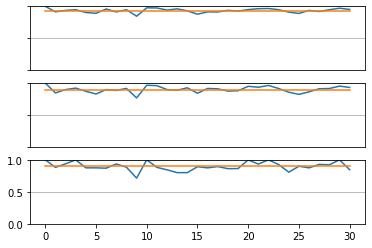

19:10:08.329834
#113 [Train: 0.216] [Test: 0.358] [Valid: 0.353]
#113 [Train: 0.932] [Test: 0.896] [Valid: 0.894]


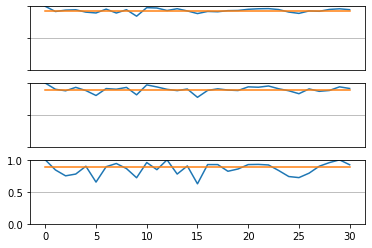

19:10:40.396213
#114 [Train: 0.212] [Test: 0.361] [Valid: 0.362]
#114 [Train: 0.933] [Test: 0.894] [Valid: 0.896]


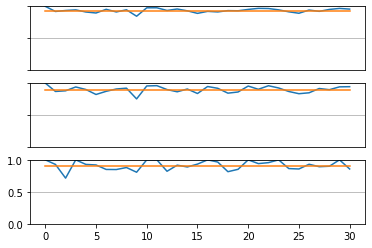

19:11:11.520632
#115 [Train: 0.212] [Test: 0.346] [Valid: 0.359]
#115 [Train: 0.933] [Test: 0.901] [Valid: 0.897]


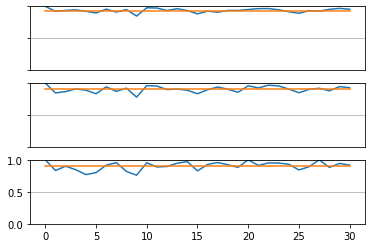

19:11:42.647859
#116 [Train: 0.208] [Test: 0.359] [Valid: 0.348]
#116 [Train: 0.936] [Test: 0.896] [Valid: 0.900]


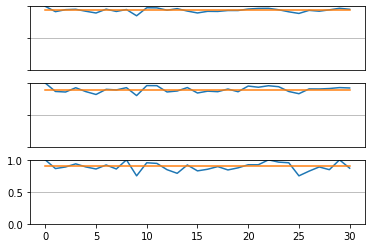

19:12:14.448843
#117 [Train: 0.208] [Test: 0.358] [Valid: 0.353]
#117 [Train: 0.935] [Test: 0.900] [Valid: 0.900]


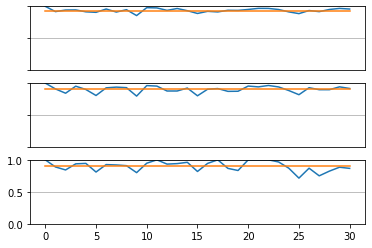

19:12:47.158526
#118 [Train: 0.212] [Test: 0.355] [Valid: 0.349]
#118 [Train: 0.933] [Test: 0.900] [Valid: 0.900]


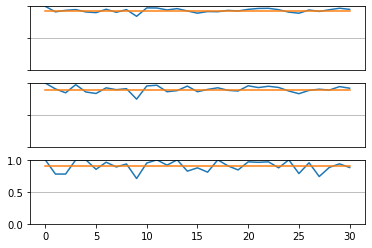

19:13:19.588108
#119 [Train: 0.201] [Test: 0.357] [Valid: 0.355]
#119 [Train: 0.936] [Test: 0.898] [Valid: 0.894]


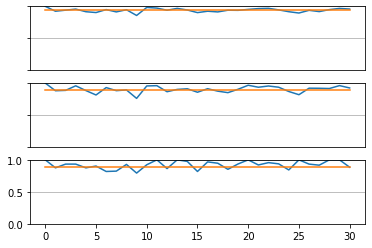

19:13:51.360332
#120 [Train: 0.203] [Test: 0.352] [Valid: 0.354]
#120 [Train: 0.937] [Test: 0.901] [Valid: 0.895]


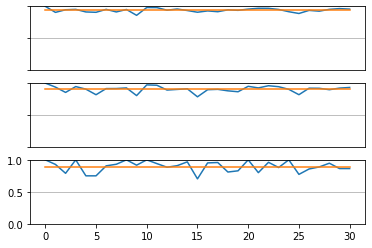

19:14:22.644327
#121 [Train: 0.201] [Test: 0.375] [Valid: 0.349]
#121 [Train: 0.936] [Test: 0.900] [Valid: 0.898]


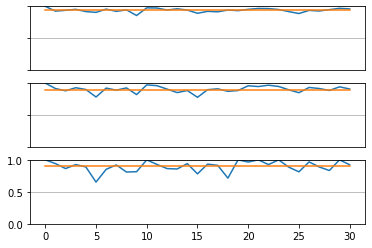

19:14:53.879748
#122 [Train: 0.198] [Test: 0.365] [Valid: 0.358]
#122 [Train: 0.937] [Test: 0.899] [Valid: 0.898]


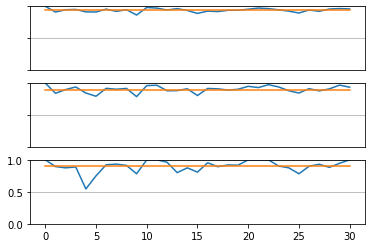

19:15:24.811746
#123 [Train: 0.199] [Test: 0.359] [Valid: 0.349]
#123 [Train: 0.938] [Test: 0.898] [Valid: 0.900]


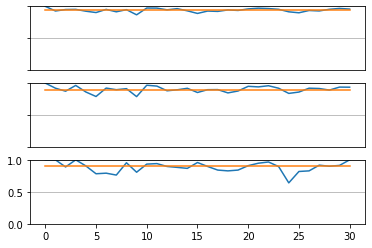

19:15:56.914162
#124 [Train: 0.193] [Test: 0.347] [Valid: 0.347]
#124 [Train: 0.940] [Test: 0.898] [Valid: 0.903]


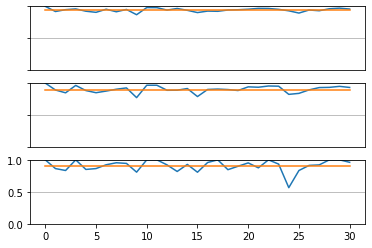

19:16:28.117452
#125 [Train: 0.191] [Test: 0.351] [Valid: 0.354]
#125 [Train: 0.940] [Test: 0.902] [Valid: 0.895]


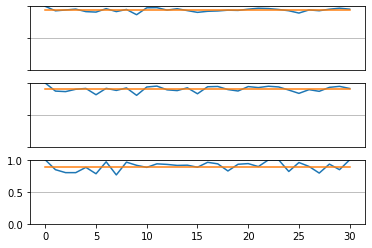

19:16:59.351250
#126 [Train: 0.190] [Test: 0.343] [Valid: 0.349]
#126 [Train: 0.939] [Test: 0.901] [Valid: 0.901]


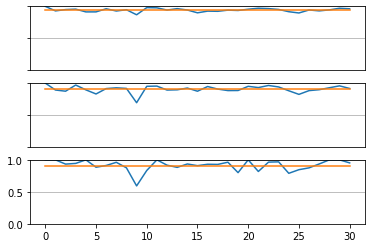

19:17:30.637214
#127 [Train: 0.186] [Test: 0.349] [Valid: 0.347]
#127 [Train: 0.941] [Test: 0.898] [Valid: 0.906]


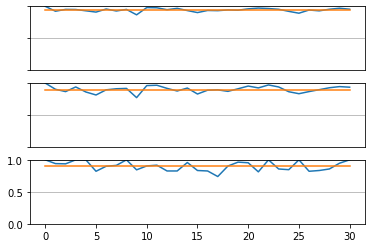

19:18:01.799787
#128 [Train: 0.184] [Test: 0.347] [Valid: 0.342]
#128 [Train: 0.942] [Test: 0.902] [Valid: 0.906]


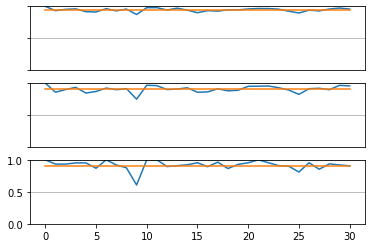

19:18:32.857290
#129 [Train: 0.182] [Test: 0.342] [Valid: 0.346]
#129 [Train: 0.943] [Test: 0.904] [Valid: 0.901]


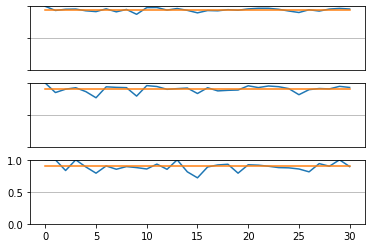

19:19:03.987294
#130 [Train: 0.188] [Test: 0.366] [Valid: 0.353]
#130 [Train: 0.941] [Test: 0.891] [Valid: 0.898]


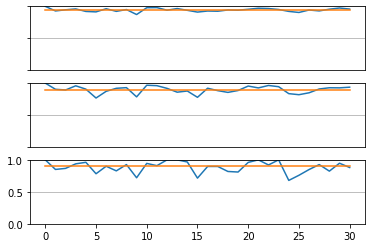

19:19:35.676388
#131 [Train: 0.183] [Test: 0.348] [Valid: 0.345]
#131 [Train: 0.942] [Test: 0.904] [Valid: 0.902]


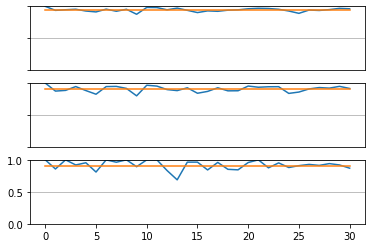

19:20:09.743503
#132 [Train: 0.181] [Test: 0.352] [Valid: 0.340]
#132 [Train: 0.943] [Test: 0.901] [Valid: 0.905]


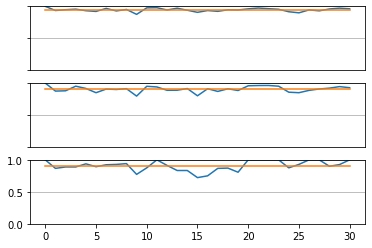

19:20:41.280824
#133 [Train: 0.180] [Test: 0.356] [Valid: 0.352]
#133 [Train: 0.943] [Test: 0.902] [Valid: 0.903]


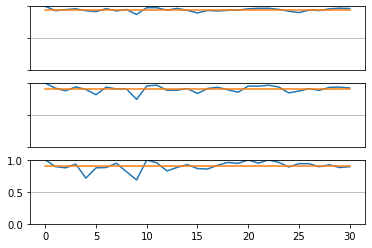

19:21:13.394746
#134 [Train: 0.178] [Test: 0.355] [Valid: 0.362]
#134 [Train: 0.944] [Test: 0.905] [Valid: 0.899]


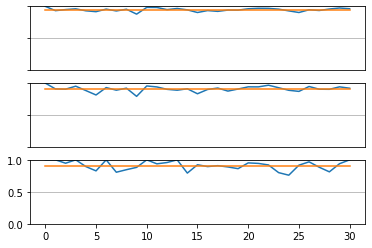

19:21:44.976418
#135 [Train: 0.177] [Test: 0.356] [Valid: 0.350]
#135 [Train: 0.945] [Test: 0.899] [Valid: 0.901]


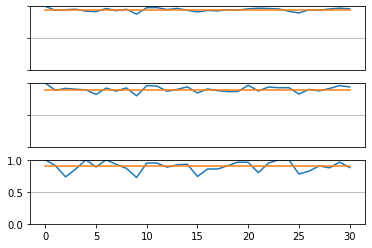

19:22:16.343454
#136 [Train: 0.171] [Test: 0.351] [Valid: 0.349]
#136 [Train: 0.945] [Test: 0.903] [Valid: 0.905]


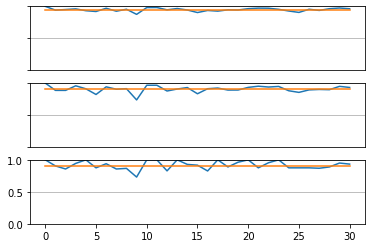

19:22:47.496887
#137 [Train: 0.169] [Test: 0.339] [Valid: 0.350]
#137 [Train: 0.947] [Test: 0.905] [Valid: 0.905]


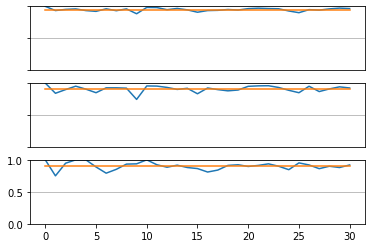

19:23:18.947150
#138 [Train: 0.173] [Test: 0.335] [Valid: 0.332]
#138 [Train: 0.946] [Test: 0.907] [Valid: 0.907]


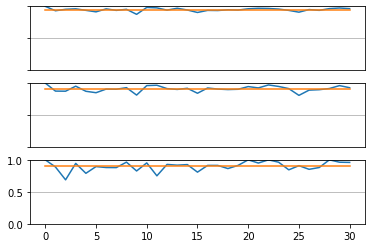

19:23:50.112026
#139 [Train: 0.169] [Test: 0.333] [Valid: 0.341]
#139 [Train: 0.946] [Test: 0.905] [Valid: 0.905]


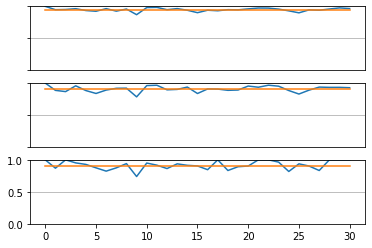

19:24:21.267217
#140 [Train: 0.168] [Test: 0.334] [Valid: 0.335]
#140 [Train: 0.947] [Test: 0.907] [Valid: 0.906]


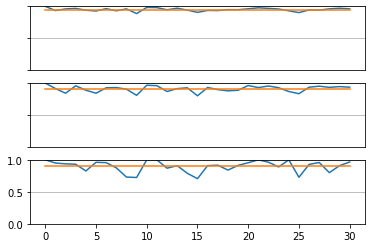

19:24:52.466131
#141 [Train: 0.165] [Test: 0.342] [Valid: 0.357]
#141 [Train: 0.948] [Test: 0.906] [Valid: 0.900]


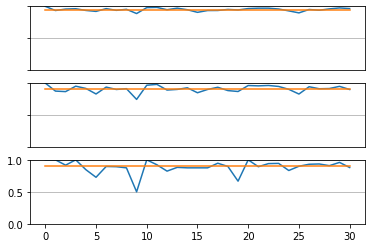

19:25:23.699462
#142 [Train: 0.161] [Test: 0.337] [Valid: 0.348]
#142 [Train: 0.949] [Test: 0.906] [Valid: 0.902]


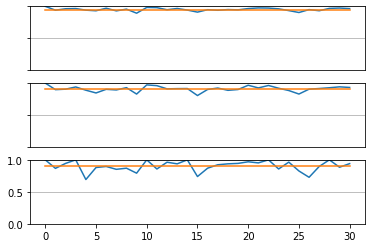

19:25:54.780552
#143 [Train: 0.162] [Test: 0.341] [Valid: 0.351]
#143 [Train: 0.948] [Test: 0.905] [Valid: 0.904]


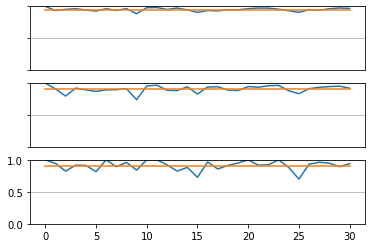

19:26:26.580303
#144 [Train: 0.161] [Test: 0.344] [Valid: 0.353]
#144 [Train: 0.949] [Test: 0.906] [Valid: 0.905]


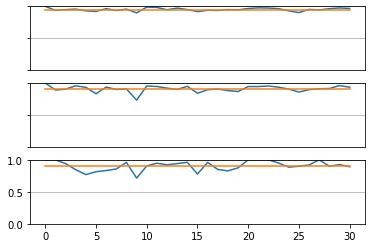

19:26:57.408373
#145 [Train: 0.156] [Test: 0.329] [Valid: 0.331]
#145 [Train: 0.950] [Test: 0.908] [Valid: 0.908]


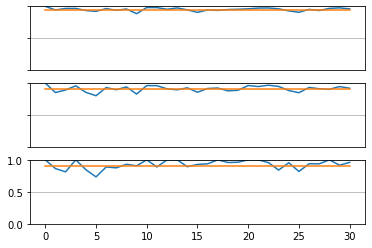

19:27:29.039741
#146 [Train: 0.160] [Test: 0.344] [Valid: 0.344]
#146 [Train: 0.949] [Test: 0.908] [Valid: 0.904]


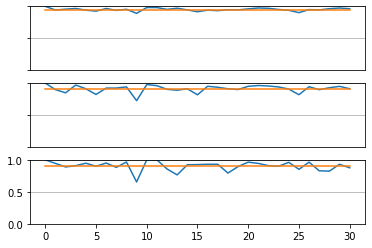

19:28:00.288667
#147 [Train: 0.155] [Test: 0.339] [Valid: 0.324]
#147 [Train: 0.951] [Test: 0.905] [Valid: 0.909]


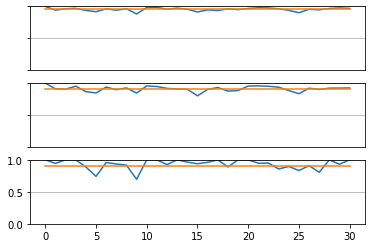

19:28:32.302454
#148 [Train: 0.153] [Test: 0.331] [Valid: 0.339]
#148 [Train: 0.952] [Test: 0.913] [Valid: 0.907]


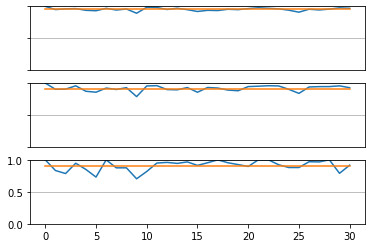

19:29:03.362511
#149 [Train: 0.159] [Test: 0.339] [Valid: 0.358]
#149 [Train: 0.950] [Test: 0.908] [Valid: 0.905]


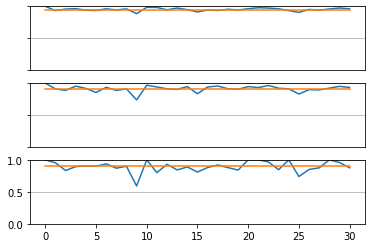

19:29:34.476113
#150 [Train: 0.155] [Test: 0.330] [Valid: 0.328]
#150 [Train: 0.951] [Test: 0.909] [Valid: 0.905]


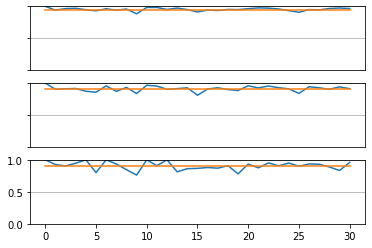

19:30:06.193621
#151 [Train: 0.149] [Test: 0.338] [Valid: 0.328]
#151 [Train: 0.954] [Test: 0.907] [Valid: 0.907]


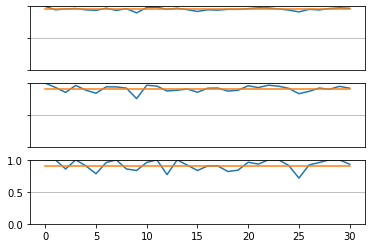

19:30:37.109890
#152 [Train: 0.152] [Test: 0.348] [Valid: 0.349]
#152 [Train: 0.951] [Test: 0.908] [Valid: 0.906]


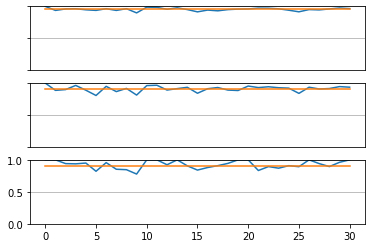

19:31:08.306260
#153 [Train: 0.150] [Test: 0.338] [Valid: 0.347]
#153 [Train: 0.953] [Test: 0.909] [Valid: 0.905]


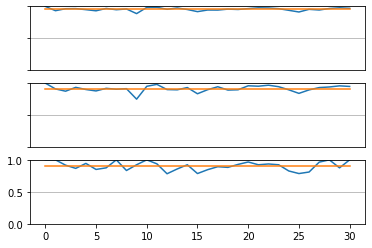

19:31:39.587748
#154 [Train: 0.148] [Test: 0.359] [Valid: 0.352]
#154 [Train: 0.953] [Test: 0.902] [Valid: 0.906]


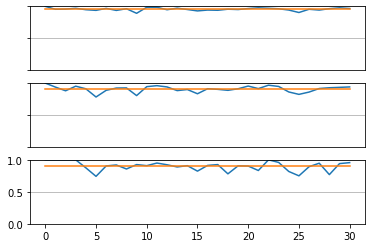

19:32:10.872598
#155 [Train: 0.148] [Test: 0.325] [Valid: 0.347]
#155 [Train: 0.953] [Test: 0.910] [Valid: 0.904]


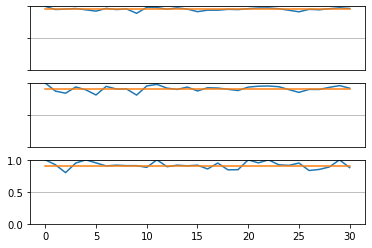

19:32:42.372308
#156 [Train: 0.147] [Test: 0.330] [Valid: 0.338]
#156 [Train: 0.953] [Test: 0.913] [Valid: 0.907]


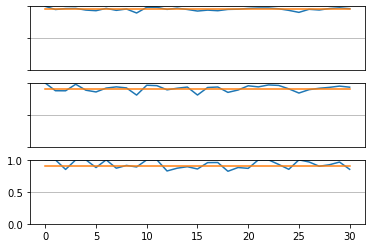

19:33:13.655032
#157 [Train: 0.147] [Test: 0.339] [Valid: 0.346]
#157 [Train: 0.953] [Test: 0.908] [Valid: 0.905]


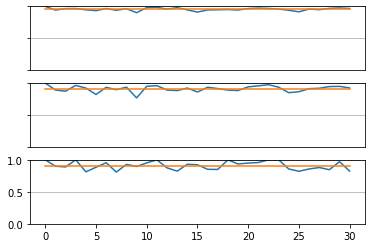

19:33:45.267598
#158 [Train: 0.143] [Test: 0.338] [Valid: 0.344]
#158 [Train: 0.955] [Test: 0.909] [Valid: 0.908]


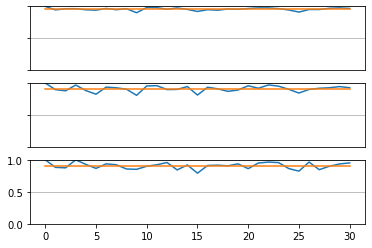

19:34:16.595306
#159 [Train: 0.142] [Test: 0.334] [Valid: 0.336]
#159 [Train: 0.954] [Test: 0.912] [Valid: 0.911]


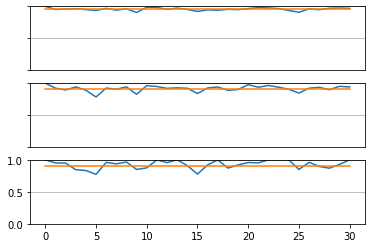

19:34:48.515420
#160 [Train: 0.141] [Test: 0.342] [Valid: 0.339]
#160 [Train: 0.955] [Test: 0.907] [Valid: 0.907]


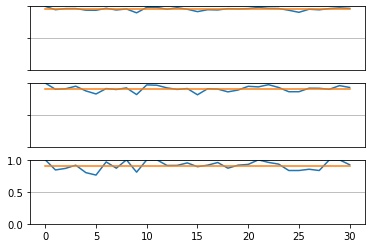

19:35:19.848644
#161 [Train: 0.143] [Test: 0.338] [Valid: 0.347]
#161 [Train: 0.954] [Test: 0.910] [Valid: 0.906]


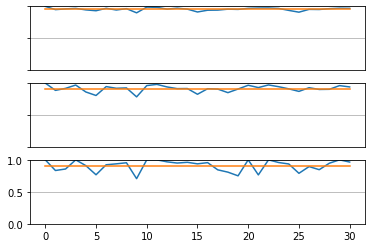

19:35:53.567769
#162 [Train: 0.138] [Test: 0.340] [Valid: 0.353]
#162 [Train: 0.956] [Test: 0.907] [Valid: 0.907]


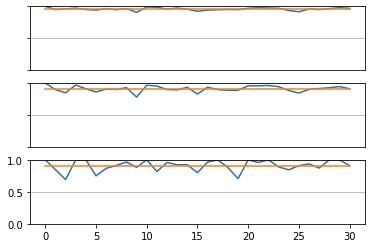

19:36:26.436948
#163 [Train: 0.137] [Test: 0.328] [Valid: 0.330]
#163 [Train: 0.957] [Test: 0.912] [Valid: 0.910]


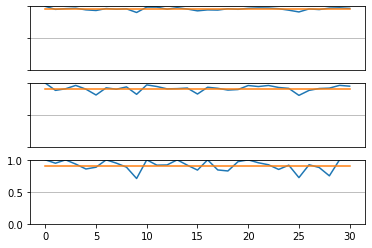

19:36:59.520981
#164 [Train: 0.137] [Test: 0.330] [Valid: 0.341]
#164 [Train: 0.956] [Test: 0.912] [Valid: 0.912]


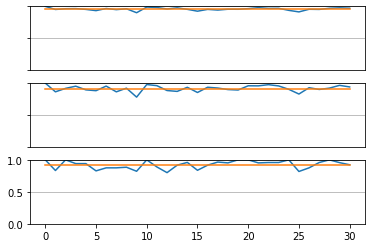

19:37:32.676129
#165 [Train: 0.134] [Test: 0.339] [Valid: 0.347]
#165 [Train: 0.957] [Test: 0.907] [Valid: 0.906]


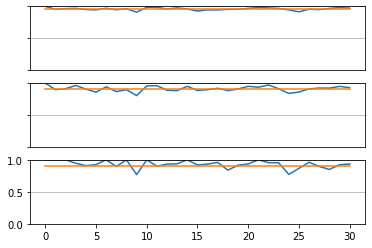

19:38:04.379958
#166 [Train: 0.136] [Test: 0.342] [Valid: 0.344]
#166 [Train: 0.957] [Test: 0.908] [Valid: 0.908]


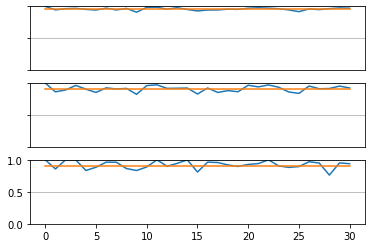

19:38:36.025099
#167 [Train: 0.133] [Test: 0.336] [Valid: 0.360]
#167 [Train: 0.959] [Test: 0.913] [Valid: 0.905]


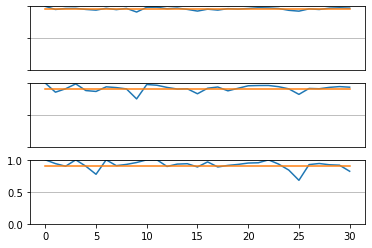

19:39:07.917659
#168 [Train: 0.131] [Test: 0.337] [Valid: 0.352]
#168 [Train: 0.958] [Test: 0.913] [Valid: 0.905]


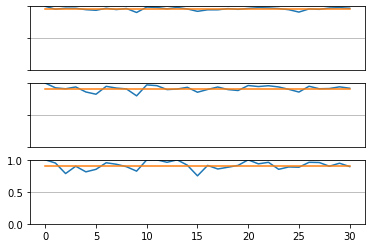

19:39:39.757046
#169 [Train: 0.129] [Test: 0.335] [Valid: 0.346]
#169 [Train: 0.959] [Test: 0.908] [Valid: 0.910]


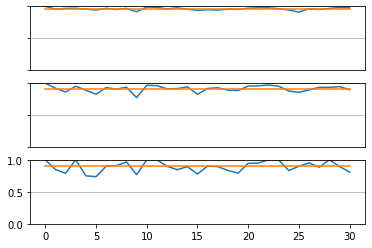

19:40:11.580096
#170 [Train: 0.131] [Test: 0.335] [Valid: 0.333]
#170 [Train: 0.959] [Test: 0.911] [Valid: 0.911]


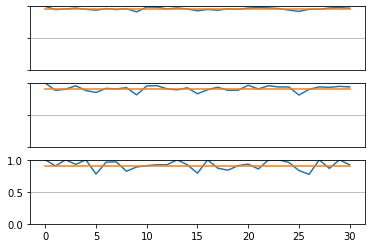

19:40:43.777106
#171 [Train: 0.125] [Test: 0.330] [Valid: 0.347]
#171 [Train: 0.960] [Test: 0.914] [Valid: 0.910]


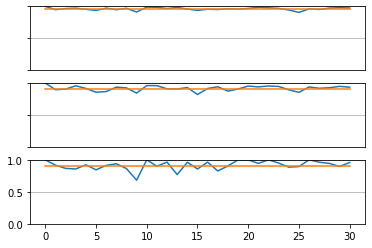

19:41:15.937977
#172 [Train: 0.128] [Test: 0.337] [Valid: 0.344]
#172 [Train: 0.959] [Test: 0.914] [Valid: 0.908]


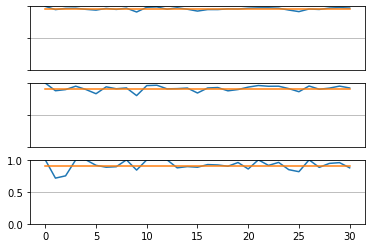

19:41:47.665360
#173 [Train: 0.126] [Test: 0.359] [Valid: 0.341]
#173 [Train: 0.960] [Test: 0.906] [Valid: 0.908]


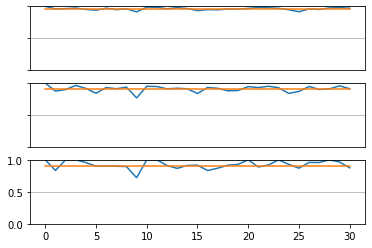

19:42:19.955121
#174 [Train: 0.128] [Test: 0.328] [Valid: 0.336]
#174 [Train: 0.959] [Test: 0.914] [Valid: 0.911]


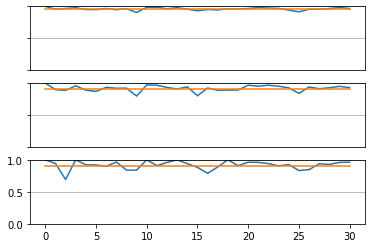

19:42:53.096759
#175 [Train: 0.125] [Test: 0.329] [Valid: 0.328]
#175 [Train: 0.960] [Test: 0.914] [Valid: 0.914]


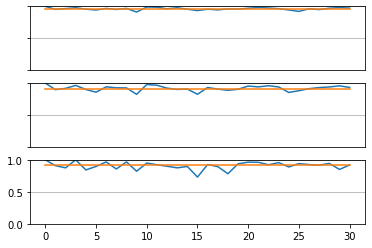

19:43:25.524515
#176 [Train: 0.123] [Test: 0.321] [Valid: 0.320]
#176 [Train: 0.961] [Test: 0.915] [Valid: 0.916]


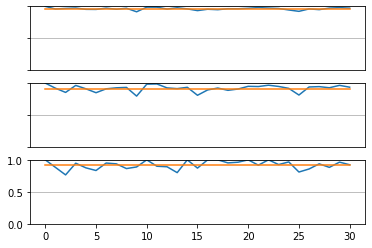

19:43:58.584412
#177 [Train: 0.121] [Test: 0.339] [Valid: 0.327]
#177 [Train: 0.962] [Test: 0.912] [Valid: 0.914]


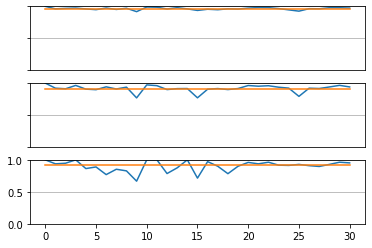

19:44:30.096122
#178 [Train: 0.121] [Test: 0.338] [Valid: 0.343]
#178 [Train: 0.962] [Test: 0.911] [Valid: 0.909]


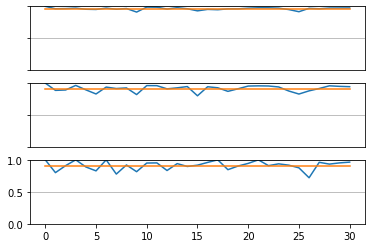

19:45:02.100598
#179 [Train: 0.124] [Test: 0.330] [Valid: 0.346]
#179 [Train: 0.960] [Test: 0.911] [Valid: 0.906]


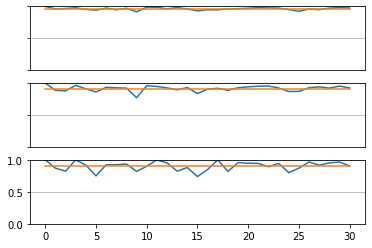

19:45:34.107119
#180 [Train: 0.121] [Test: 0.320] [Valid: 0.350]
#180 [Train: 0.960] [Test: 0.913] [Valid: 0.910]


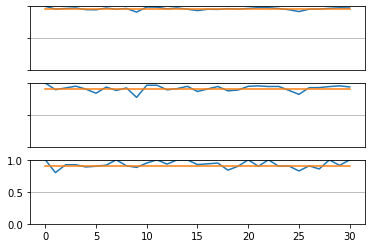

19:46:06.266398
#181 [Train: 0.119] [Test: 0.346] [Valid: 0.360]
#181 [Train: 0.962] [Test: 0.913] [Valid: 0.908]


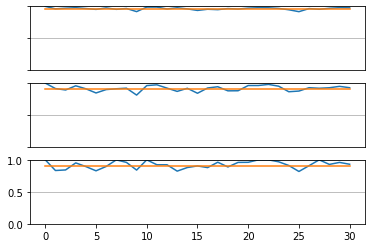

19:46:38.051918
#182 [Train: 0.119] [Test: 0.341] [Valid: 0.354]
#182 [Train: 0.962] [Test: 0.909] [Valid: 0.905]


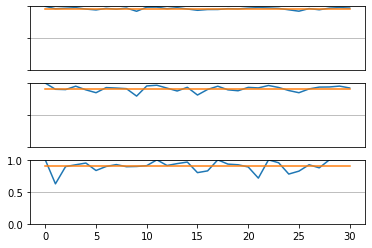

19:47:09.360389
#183 [Train: 0.120] [Test: 0.342] [Valid: 0.346]
#183 [Train: 0.962] [Test: 0.911] [Valid: 0.910]


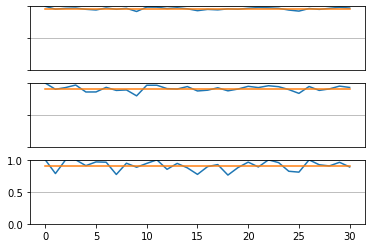

19:47:41.091071
#184 [Train: 0.118] [Test: 0.339] [Valid: 0.349]
#184 [Train: 0.962] [Test: 0.910] [Valid: 0.912]


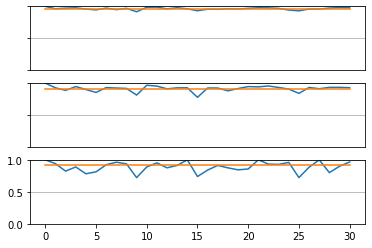

19:48:12.432970
#185 [Train: 0.117] [Test: 0.330] [Valid: 0.333]
#185 [Train: 0.962] [Test: 0.915] [Valid: 0.910]


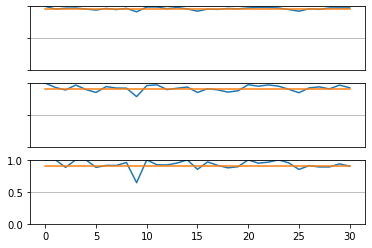

19:48:43.932701
#186 [Train: 0.115] [Test: 0.335] [Valid: 0.345]
#186 [Train: 0.964] [Test: 0.914] [Valid: 0.910]


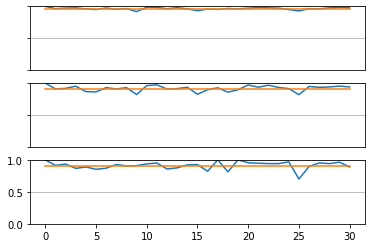

19:49:15.841149
#187 [Train: 0.117] [Test: 0.331] [Valid: 0.329]
#187 [Train: 0.963] [Test: 0.916] [Valid: 0.913]


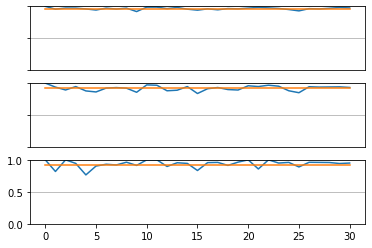

19:49:46.859779
#188 [Train: 0.113] [Test: 0.329] [Valid: 0.355]
#188 [Train: 0.964] [Test: 0.914] [Valid: 0.913]


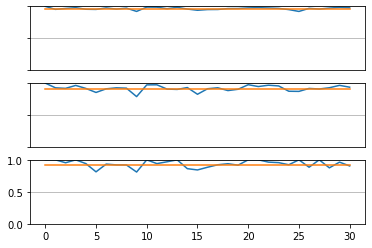

19:50:18.967793
#189 [Train: 0.112] [Test: 0.323] [Valid: 0.344]
#189 [Train: 0.965] [Test: 0.916] [Valid: 0.914]


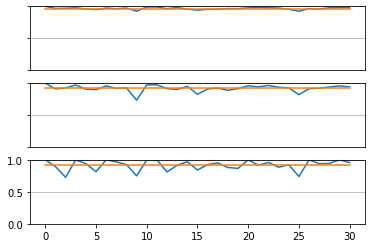

19:50:50.434778
#190 [Train: 0.109] [Test: 0.336] [Valid: 0.345]
#190 [Train: 0.965] [Test: 0.915] [Valid: 0.912]


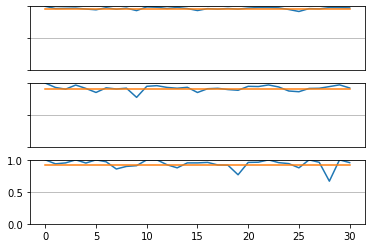

19:51:23.199945
#191 [Train: 0.110] [Test: 0.339] [Valid: 0.345]
#191 [Train: 0.965] [Test: 0.916] [Valid: 0.910]


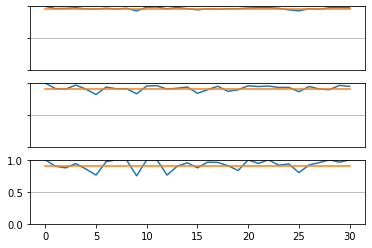

19:51:56.387407
#192 [Train: 0.107] [Test: 0.352] [Valid: 0.347]
#192 [Train: 0.966] [Test: 0.910] [Valid: 0.914]


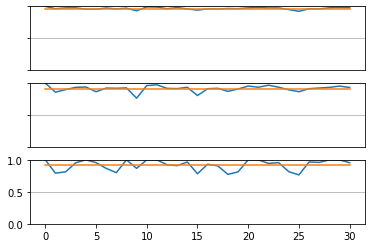

19:52:29.640873
#193 [Train: 0.109] [Test: 0.338] [Valid: 0.368]
#193 [Train: 0.966] [Test: 0.915] [Valid: 0.908]


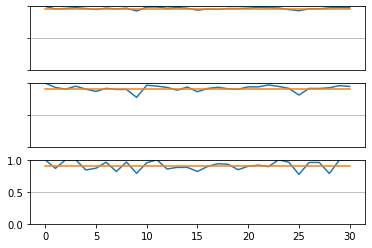

19:53:03.060113
#194 [Train: 0.112] [Test: 0.329] [Valid: 0.321]
#194 [Train: 0.964] [Test: 0.915] [Valid: 0.915]


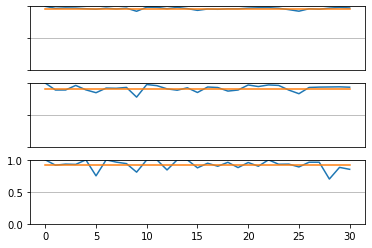

19:53:35.304578
#195 [Train: 0.108] [Test: 0.325] [Valid: 0.344]
#195 [Train: 0.966] [Test: 0.916] [Valid: 0.911]


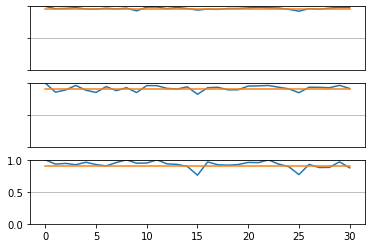

19:54:06.826869
#196 [Train: 0.108] [Test: 0.338] [Valid: 0.351]
#196 [Train: 0.966] [Test: 0.914] [Valid: 0.914]


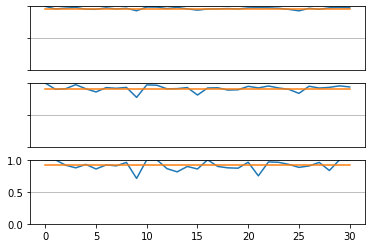

19:54:38.330781
#197 [Train: 0.108] [Test: 0.341] [Valid: 0.356]
#197 [Train: 0.966] [Test: 0.914] [Valid: 0.909]


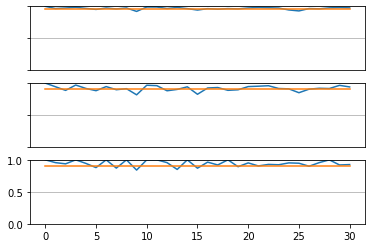

19:55:10.059248
#198 [Train: 0.105] [Test: 0.334] [Valid: 0.338]
#198 [Train: 0.967] [Test: 0.914] [Valid: 0.914]


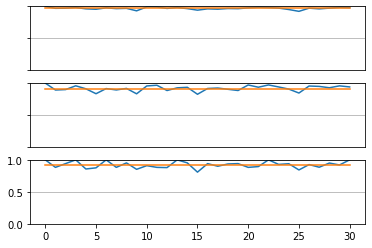

19:55:42.229186
#199 [Train: 0.106] [Test: 0.325] [Valid: 0.341]
#199 [Train: 0.965] [Test: 0.914] [Valid: 0.913]


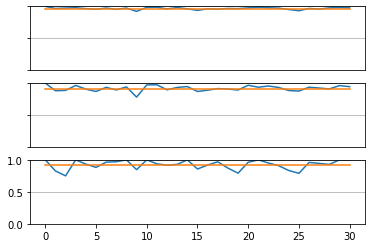

19:56:14.087414
#200 [Train: 0.101] [Test: 0.345] [Valid: 0.347]
#200 [Train: 0.968] [Test: 0.919] [Valid: 0.913]


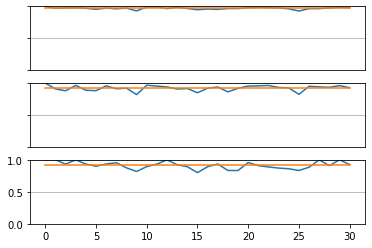

19:56:45.576815
#201 [Train: 0.100] [Test: 0.365] [Valid: 0.358]
#201 [Train: 0.968] [Test: 0.912] [Valid: 0.912]


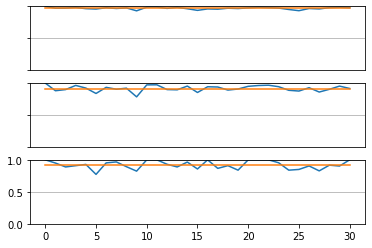

19:57:16.763314
#202 [Train: 0.101] [Test: 0.347] [Valid: 0.349]
#202 [Train: 0.968] [Test: 0.914] [Valid: 0.911]


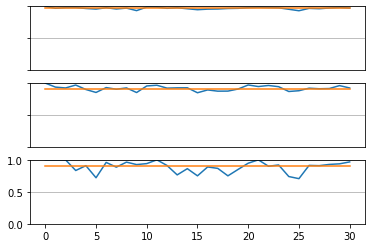

19:57:47.844158
#203 [Train: 0.102] [Test: 0.343] [Valid: 0.339]
#203 [Train: 0.968] [Test: 0.914] [Valid: 0.912]


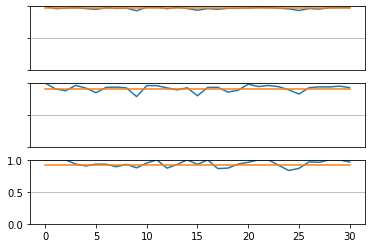

19:58:19.152927
#204 [Train: 0.099] [Test: 0.344] [Valid: 0.366]
#204 [Train: 0.969] [Test: 0.914] [Valid: 0.911]


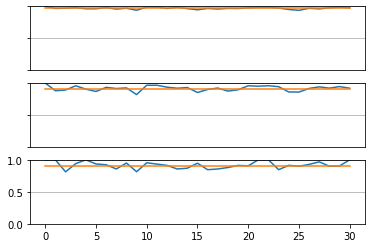

19:58:50.513256
#205 [Train: 0.100] [Test: 0.349] [Valid: 0.348]
#205 [Train: 0.969] [Test: 0.913] [Valid: 0.913]


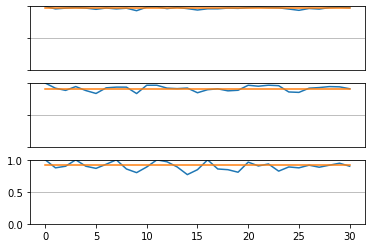

19:59:22.574455
#206 [Train: 0.098] [Test: 0.360] [Valid: 0.358]
#206 [Train: 0.969] [Test: 0.911] [Valid: 0.911]


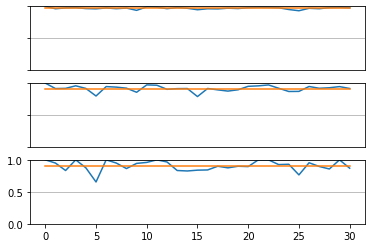

19:59:54.000983
#207 [Train: 0.097] [Test: 0.350] [Valid: 0.353]
#207 [Train: 0.969] [Test: 0.913] [Valid: 0.913]


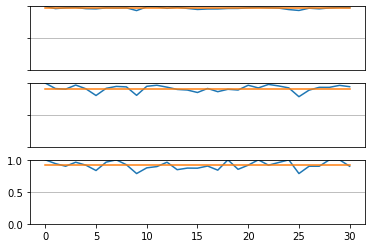

20:00:25.558345
#208 [Train: 0.099] [Test: 0.350] [Valid: 0.368]
#208 [Train: 0.968] [Test: 0.911] [Valid: 0.908]


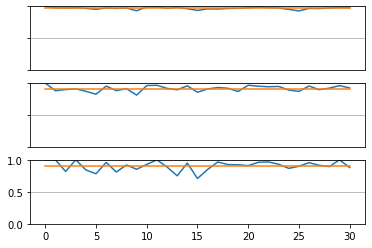

20:00:56.928990
#209 [Train: 0.096] [Test: 0.334] [Valid: 0.348]
#209 [Train: 0.969] [Test: 0.918] [Valid: 0.914]


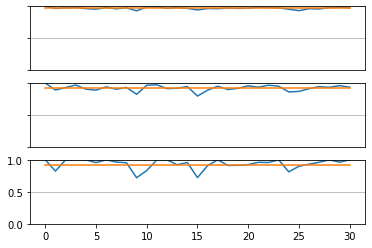

20:01:28.200284
#210 [Train: 0.095] [Test: 0.345] [Valid: 0.345]
#210 [Train: 0.969] [Test: 0.915] [Valid: 0.911]


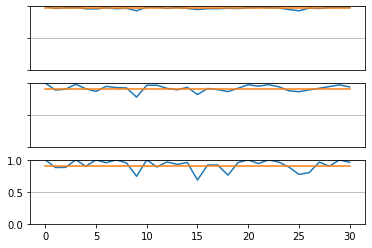

20:02:01.008791
#211 [Train: 0.095] [Test: 0.344] [Valid: 0.357]
#211 [Train: 0.970] [Test: 0.915] [Valid: 0.914]


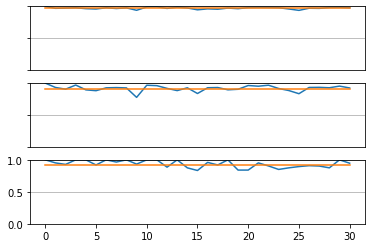

20:02:32.667311
#212 [Train: 0.097] [Test: 0.348] [Valid: 0.343]
#212 [Train: 0.968] [Test: 0.911] [Valid: 0.917]


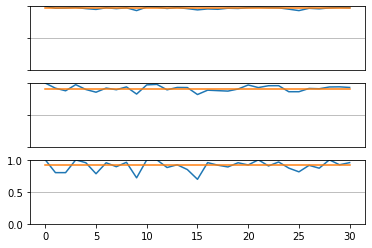

20:03:03.792608
#213 [Train: 0.092] [Test: 0.355] [Valid: 0.355]
#213 [Train: 0.970] [Test: 0.913] [Valid: 0.911]


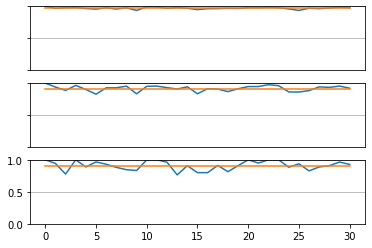

20:03:34.750976
#214 [Train: 0.097] [Test: 0.339] [Valid: 0.355]
#214 [Train: 0.969] [Test: 0.916] [Valid: 0.914]


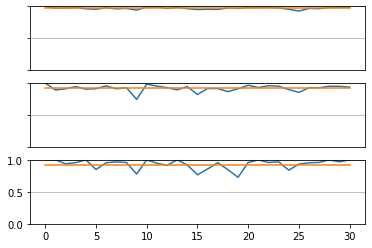

20:04:06.491965
#215 [Train: 0.091] [Test: 0.330] [Valid: 0.342]
#215 [Train: 0.971] [Test: 0.915] [Valid: 0.913]


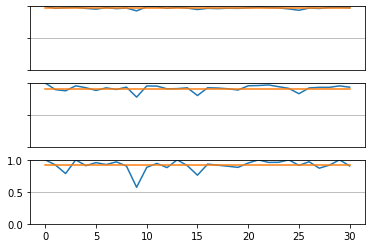

20:04:37.802074
#216 [Train: 0.094] [Test: 0.354] [Valid: 0.355]
#216 [Train: 0.970] [Test: 0.917] [Valid: 0.913]


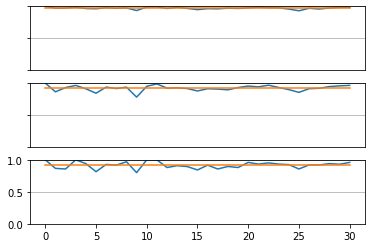

20:05:09.012636
#217 [Train: 0.091] [Test: 0.348] [Valid: 0.356]
#217 [Train: 0.971] [Test: 0.916] [Valid: 0.916]


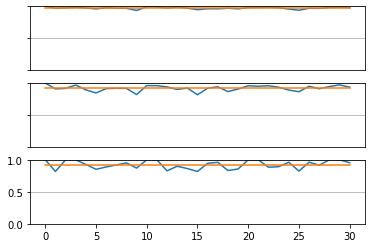

20:05:40.179475
#218 [Train: 0.089] [Test: 0.342] [Valid: 0.340]
#218 [Train: 0.971] [Test: 0.919] [Valid: 0.915]


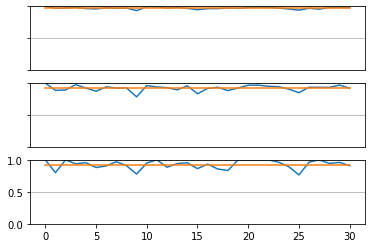

20:06:11.773100
#219 [Train: 0.090] [Test: 0.340] [Valid: 0.336]
#219 [Train: 0.971] [Test: 0.916] [Valid: 0.915]


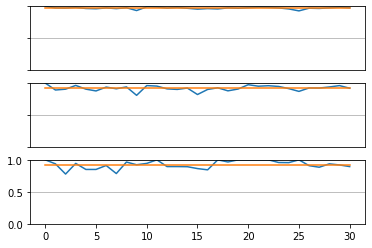

20:06:43.489189
#220 [Train: 0.090] [Test: 0.343] [Valid: 0.357]
#220 [Train: 0.971] [Test: 0.916] [Valid: 0.913]


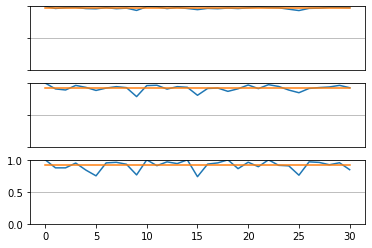

20:07:15.180157
#221 [Train: 0.087] [Test: 0.355] [Valid: 0.343]
#221 [Train: 0.972] [Test: 0.914] [Valid: 0.916]


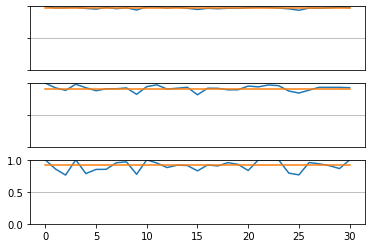

20:07:48.312169
#222 [Train: 0.090] [Test: 0.354] [Valid: 0.362]
#222 [Train: 0.971] [Test: 0.915] [Valid: 0.914]


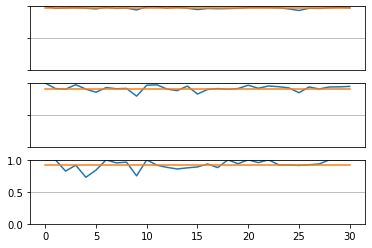

20:08:19.860792
#223 [Train: 0.089] [Test: 0.361] [Valid: 0.370]
#223 [Train: 0.972] [Test: 0.915] [Valid: 0.912]


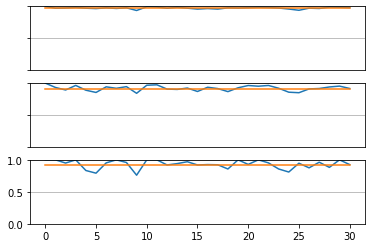

20:08:51.059545
#224 [Train: 0.091] [Test: 0.335] [Valid: 0.347]
#224 [Train: 0.971] [Test: 0.915] [Valid: 0.914]


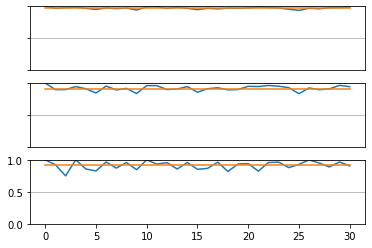

20:09:22.384056
#225 [Train: 0.086] [Test: 0.368] [Valid: 0.358]
#225 [Train: 0.972] [Test: 0.914] [Valid: 0.913]


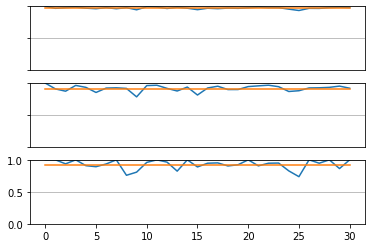

20:09:53.679027
#226 [Train: 0.088] [Test: 0.347] [Valid: 0.379]
#226 [Train: 0.972] [Test: 0.920] [Valid: 0.907]


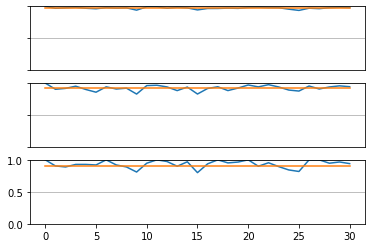

20:10:24.896452
#227 [Train: 0.085] [Test: 0.356] [Valid: 0.364]
#227 [Train: 0.973] [Test: 0.917] [Valid: 0.915]


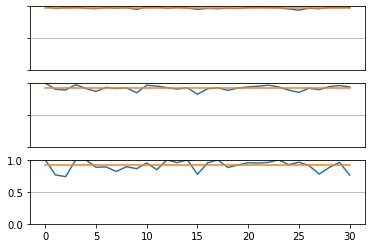

20:10:56.688132
#228 [Train: 0.085] [Test: 0.359] [Valid: 0.365]
#228 [Train: 0.973] [Test: 0.916] [Valid: 0.913]


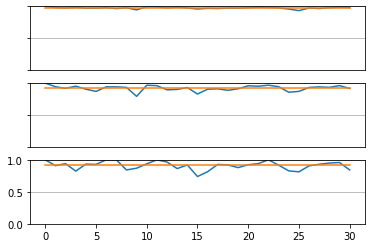

20:11:28.061433
#229 [Train: 0.089] [Test: 0.379] [Valid: 0.372]
#229 [Train: 0.972] [Test: 0.909] [Valid: 0.914]


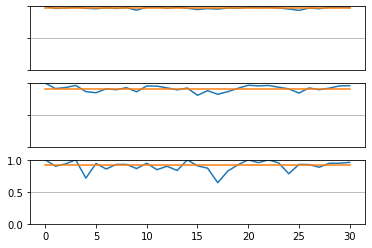

20:11:59.219004
#230 [Train: 0.084] [Test: 0.352] [Valid: 0.352]
#230 [Train: 0.973] [Test: 0.917] [Valid: 0.915]


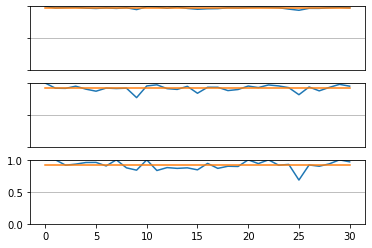

20:12:30.480851
#231 [Train: 0.082] [Test: 0.354] [Valid: 0.361]
#231 [Train: 0.974] [Test: 0.917] [Valid: 0.916]


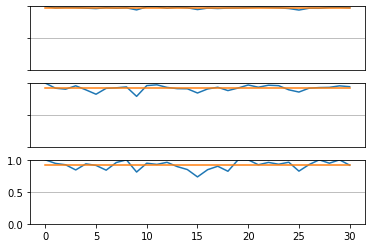

20:13:03.035219
#232 [Train: 0.084] [Test: 0.378] [Valid: 0.382]
#232 [Train: 0.973] [Test: 0.910] [Valid: 0.908]


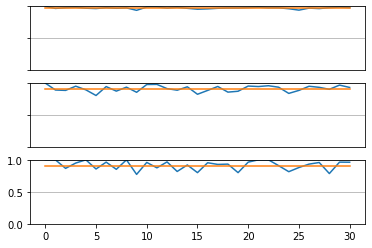

20:13:35.676489
#233 [Train: 0.080] [Test: 0.347] [Valid: 0.359]
#233 [Train: 0.974] [Test: 0.919] [Valid: 0.917]


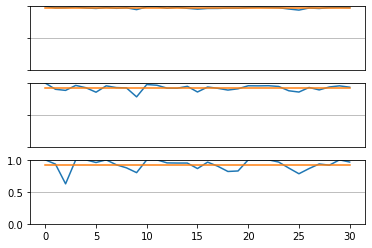

20:14:07.607830
#234 [Train: 0.080] [Test: 0.348] [Valid: 0.349]
#234 [Train: 0.975] [Test: 0.917] [Valid: 0.913]


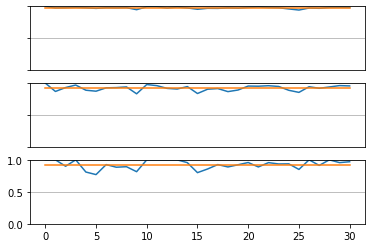

20:14:40.632470
#235 [Train: 0.080] [Test: 0.343] [Valid: 0.378]
#235 [Train: 0.975] [Test: 0.921] [Valid: 0.912]


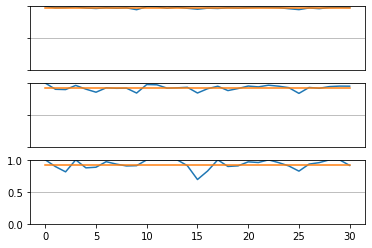

20:15:11.923719
#236 [Train: 0.081] [Test: 0.333] [Valid: 0.351]
#236 [Train: 0.974] [Test: 0.919] [Valid: 0.915]


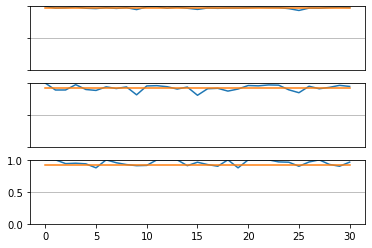

20:15:43.945234
#237 [Train: 0.081] [Test: 0.342] [Valid: 0.363]
#237 [Train: 0.974] [Test: 0.919] [Valid: 0.913]


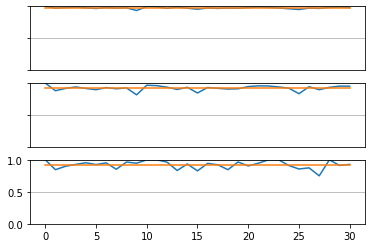

20:16:15.576557
#238 [Train: 0.081] [Test: 0.347] [Valid: 0.369]
#238 [Train: 0.974] [Test: 0.917] [Valid: 0.914]


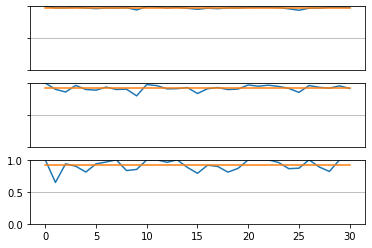

20:16:47.412688
#239 [Train: 0.077] [Test: 0.359] [Valid: 0.380]
#239 [Train: 0.976] [Test: 0.916] [Valid: 0.914]


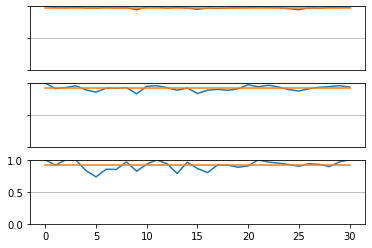

20:17:19.175771
#240 [Train: 0.082] [Test: 0.364] [Valid: 0.370]
#240 [Train: 0.974] [Test: 0.912] [Valid: 0.915]


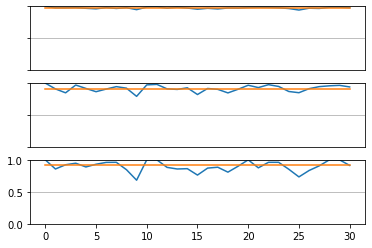

20:17:50.424739
#241 [Train: 0.080] [Test: 0.354] [Valid: 0.368]
#241 [Train: 0.975] [Test: 0.918] [Valid: 0.913]


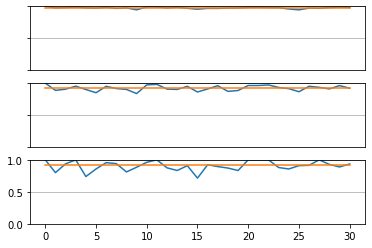

20:18:21.816048
#242 [Train: 0.075] [Test: 0.341] [Valid: 0.356]
#242 [Train: 0.976] [Test: 0.917] [Valid: 0.915]


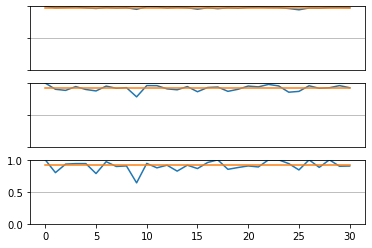

20:18:53.064566
#243 [Train: 0.074] [Test: 0.374] [Valid: 0.373]
#243 [Train: 0.976] [Test: 0.916] [Valid: 0.917]


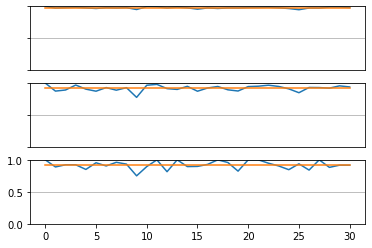

20:19:24.623915
#244 [Train: 0.075] [Test: 0.351] [Valid: 0.377]
#244 [Train: 0.976] [Test: 0.920] [Valid: 0.916]


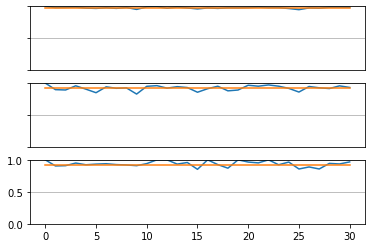

20:19:55.789032
#245 [Train: 0.074] [Test: 0.353] [Valid: 0.347]
#245 [Train: 0.977] [Test: 0.921] [Valid: 0.918]


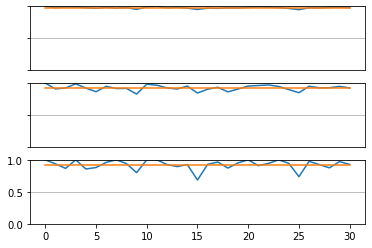

20:20:27.156051
#246 [Train: 0.072] [Test: 0.382] [Valid: 0.382]
#246 [Train: 0.977] [Test: 0.914] [Valid: 0.911]


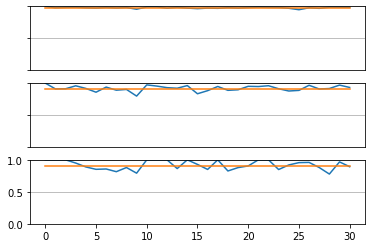

20:20:58.236434
#247 [Train: 0.079] [Test: 0.357] [Valid: 0.364]
#247 [Train: 0.975] [Test: 0.917] [Valid: 0.914]


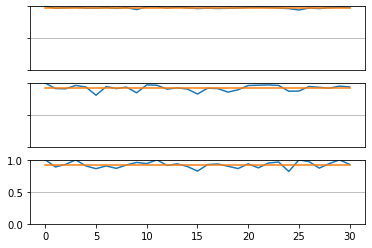

20:21:30.157397
#248 [Train: 0.074] [Test: 0.381] [Valid: 0.370]
#248 [Train: 0.976] [Test: 0.916] [Valid: 0.916]


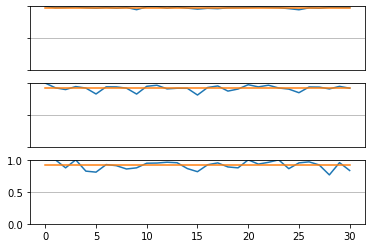

20:22:01.357092
#249 [Train: 0.074] [Test: 0.364] [Valid: 0.364]
#249 [Train: 0.976] [Test: 0.916] [Valid: 0.916]


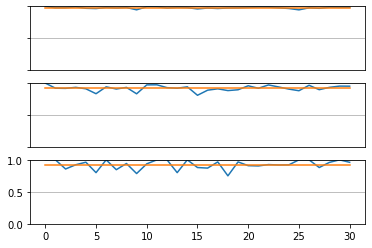

20:22:32.519489
#250 [Train: 0.073] [Test: 0.376] [Valid: 0.380]
#250 [Train: 0.977] [Test: 0.914] [Valid: 0.914]


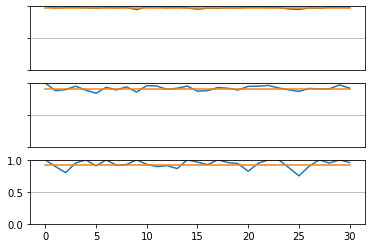

20:23:04.260614
#251 [Train: 0.076] [Test: 0.354] [Valid: 0.343]
#251 [Train: 0.976] [Test: 0.915] [Valid: 0.916]


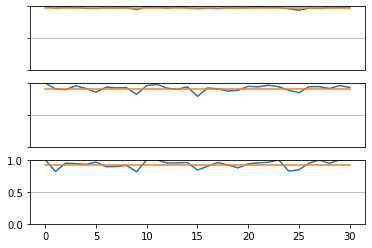

20:23:35.603146
#252 [Train: 0.074] [Test: 0.346] [Valid: 0.374]
#252 [Train: 0.976] [Test: 0.919] [Valid: 0.915]


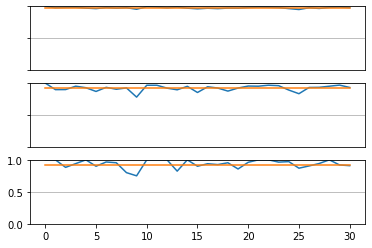

20:24:06.275429
#253 [Train: 0.072] [Test: 0.355] [Valid: 0.376]
#253 [Train: 0.977] [Test: 0.920] [Valid: 0.914]


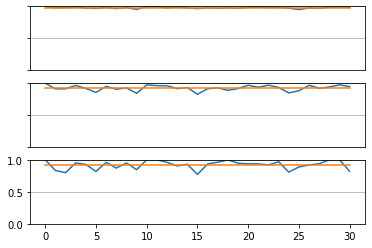

20:24:36.455576
#254 [Train: 0.073] [Test: 0.357] [Valid: 0.375]
#254 [Train: 0.977] [Test: 0.915] [Valid: 0.918]


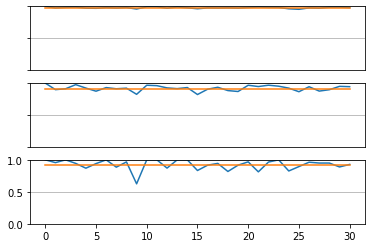

20:25:07.853171
#255 [Train: 0.073] [Test: 0.356] [Valid: 0.372]
#255 [Train: 0.977] [Test: 0.916] [Valid: 0.915]


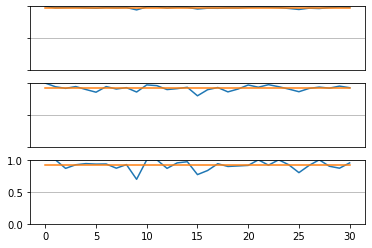

20:25:39.166912
#256 [Train: 0.071] [Test: 0.351] [Valid: 0.379]
#256 [Train: 0.978] [Test: 0.919] [Valid: 0.916]


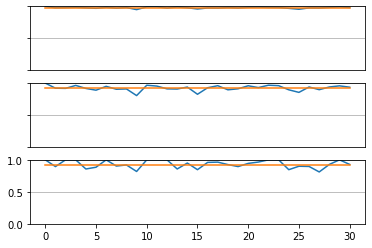

20:26:10.653168
#257 [Train: 0.070] [Test: 0.345] [Valid: 0.369]
#257 [Train: 0.977] [Test: 0.921] [Valid: 0.914]


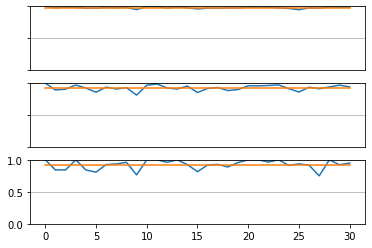

20:26:41.910120
#258 [Train: 0.073] [Test: 0.370] [Valid: 0.351]
#258 [Train: 0.977] [Test: 0.915] [Valid: 0.918]


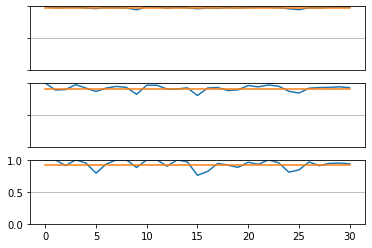

20:27:11.718459
#259 [Train: 0.070] [Test: 0.370] [Valid: 0.365]
#259 [Train: 0.977] [Test: 0.919] [Valid: 0.919]


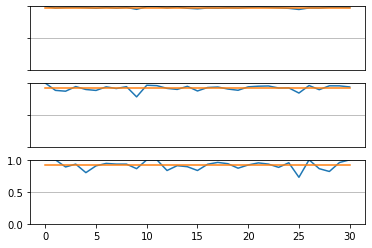

20:27:40.540481
#260 [Train: 0.067] [Test: 0.352] [Valid: 0.357]
#260 [Train: 0.979] [Test: 0.920] [Valid: 0.915]


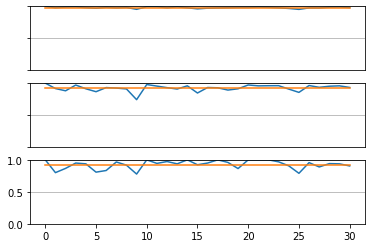

20:28:09.583213
#261 [Train: 0.072] [Test: 0.351] [Valid: 0.364]
#261 [Train: 0.977] [Test: 0.920] [Valid: 0.919]


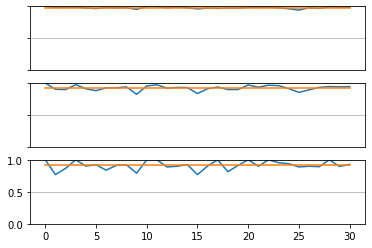

20:28:38.726450
#262 [Train: 0.069] [Test: 0.352] [Valid: 0.360]
#262 [Train: 0.978] [Test: 0.919] [Valid: 0.917]


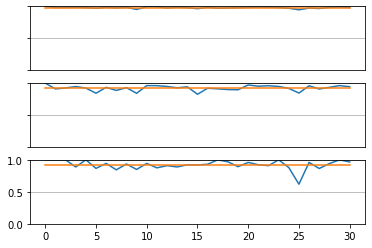

20:29:07.640236
#263 [Train: 0.067] [Test: 0.363] [Valid: 0.371]
#263 [Train: 0.979] [Test: 0.915] [Valid: 0.914]


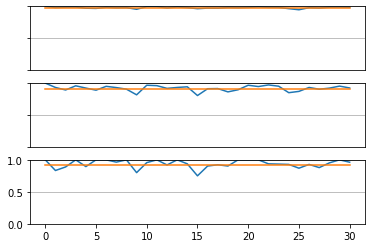

20:29:38.915382
#264 [Train: 0.067] [Test: 0.370] [Valid: 0.379]
#264 [Train: 0.978] [Test: 0.915] [Valid: 0.912]


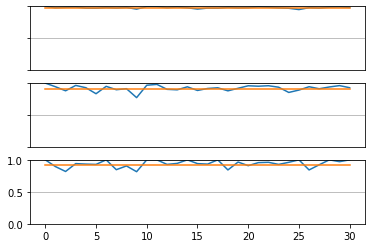

20:30:10.176556
#265 [Train: 0.064] [Test: 0.361] [Valid: 0.377]
#265 [Train: 0.980] [Test: 0.916] [Valid: 0.914]


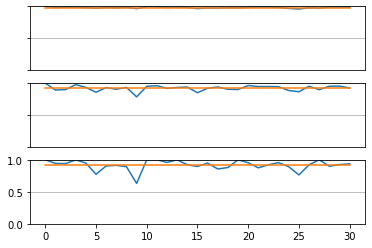

20:30:41.362263
#266 [Train: 0.068] [Test: 0.364] [Valid: 0.377]
#266 [Train: 0.978] [Test: 0.915] [Valid: 0.912]


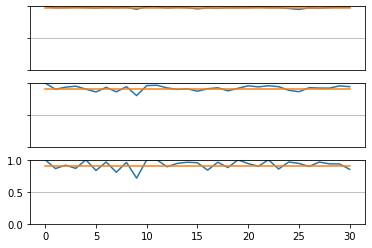

20:31:12.336607
#267 [Train: 0.067] [Test: 0.373] [Valid: 0.386]
#267 [Train: 0.979] [Test: 0.920] [Valid: 0.915]


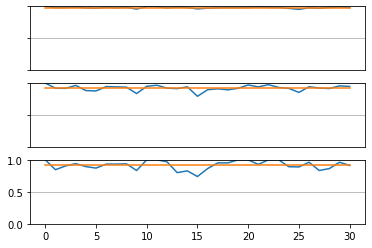

20:31:44.015757
#268 [Train: 0.066] [Test: 0.359] [Valid: 0.370]
#268 [Train: 0.979] [Test: 0.922] [Valid: 0.918]


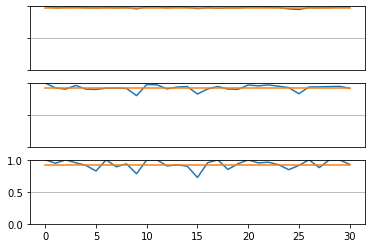

20:32:15.325358
#269 [Train: 0.064] [Test: 0.353] [Valid: 0.378]
#269 [Train: 0.980] [Test: 0.916] [Valid: 0.914]


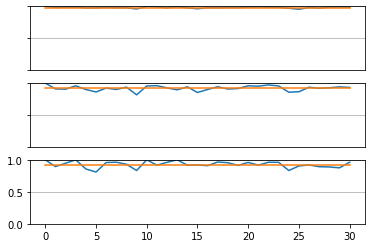

20:32:46.691121
#270 [Train: 0.064] [Test: 0.368] [Valid: 0.379]
#270 [Train: 0.980] [Test: 0.918] [Valid: 0.917]


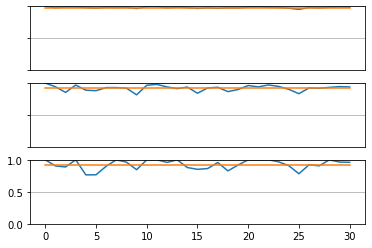

20:33:18.264870
#271 [Train: 0.065] [Test: 0.359] [Valid: 0.381]
#271 [Train: 0.980] [Test: 0.916] [Valid: 0.917]


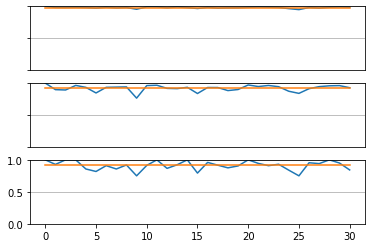

20:33:49.920395
#272 [Train: 0.064] [Test: 0.358] [Valid: 0.370]
#272 [Train: 0.979] [Test: 0.922] [Valid: 0.915]


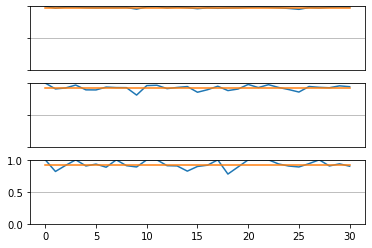

20:34:21.552401
#273 [Train: 0.064] [Test: 0.382] [Valid: 0.380]
#273 [Train: 0.980] [Test: 0.918] [Valid: 0.916]


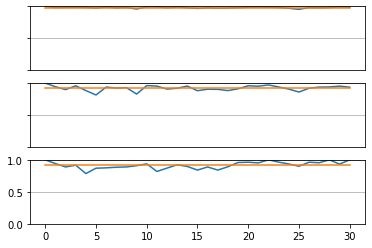

20:34:53.639937
#274 [Train: 0.060] [Test: 0.368] [Valid: 0.371]
#274 [Train: 0.981] [Test: 0.920] [Valid: 0.917]


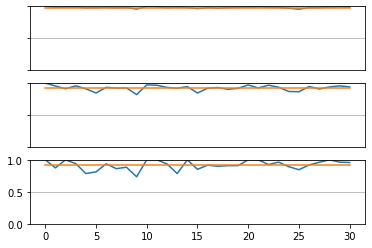

20:35:25.057592
#275 [Train: 0.062] [Test: 0.371] [Valid: 0.383]
#275 [Train: 0.980] [Test: 0.918] [Valid: 0.915]


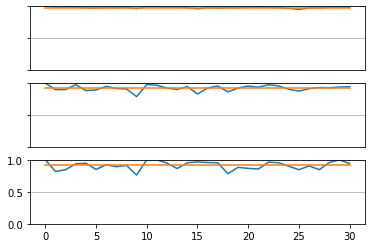

20:35:56.089671
#276 [Train: 0.065] [Test: 0.391] [Valid: 0.405]
#276 [Train: 0.979] [Test: 0.914] [Valid: 0.912]


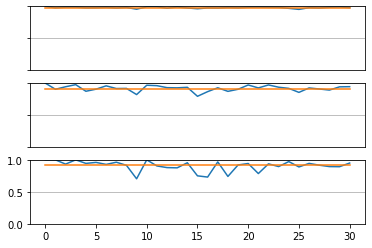

20:36:27.527997
#277 [Train: 0.064] [Test: 0.389] [Valid: 0.391]
#277 [Train: 0.980] [Test: 0.916] [Valid: 0.915]


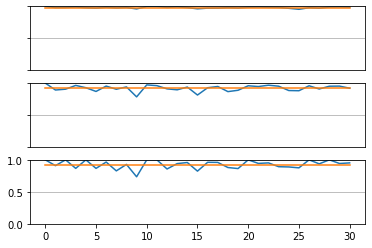

20:36:58.848879
#278 [Train: 0.063] [Test: 0.369] [Valid: 0.392]
#278 [Train: 0.980] [Test: 0.921] [Valid: 0.915]


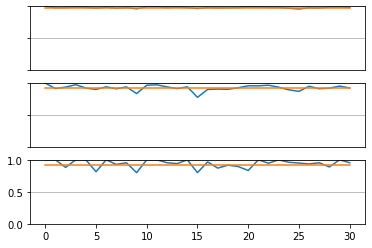

20:37:29.989240
#279 [Train: 0.063] [Test: 0.370] [Valid: 0.400]
#279 [Train: 0.980] [Test: 0.921] [Valid: 0.913]


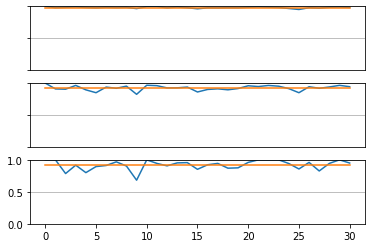

20:38:01.571716
#280 [Train: 0.062] [Test: 0.380] [Valid: 0.399]
#280 [Train: 0.981] [Test: 0.918] [Valid: 0.913]


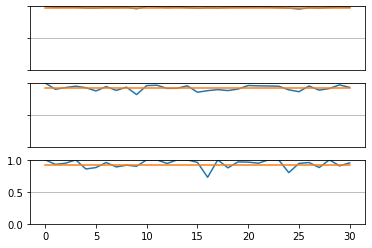

20:38:32.940119
#281 [Train: 0.065] [Test: 0.370] [Valid: 0.370]
#281 [Train: 0.979] [Test: 0.919] [Valid: 0.919]


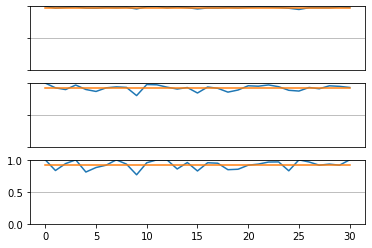

20:39:04.632266
#282 [Train: 0.061] [Test: 0.373] [Valid: 0.382]
#282 [Train: 0.981] [Test: 0.918] [Valid: 0.914]


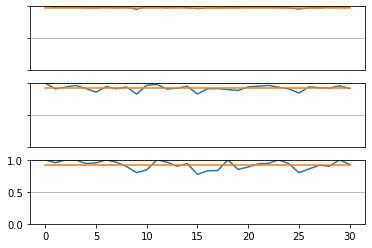

20:39:36.420566
#283 [Train: 0.058] [Test: 0.391] [Valid: 0.381]
#283 [Train: 0.982] [Test: 0.916] [Valid: 0.918]


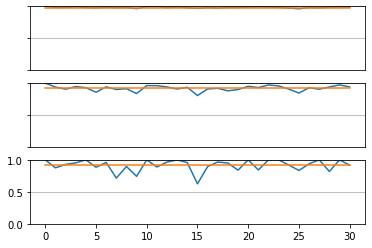

20:40:07.691645
#284 [Train: 0.060] [Test: 0.378] [Valid: 0.388]
#284 [Train: 0.981] [Test: 0.917] [Valid: 0.918]


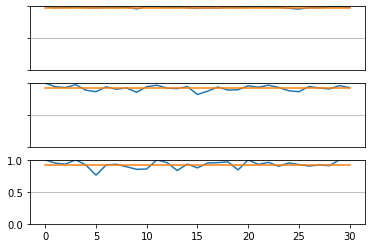

20:40:38.760929
#285 [Train: 0.064] [Test: 0.365] [Valid: 0.389]
#285 [Train: 0.980] [Test: 0.921] [Valid: 0.915]


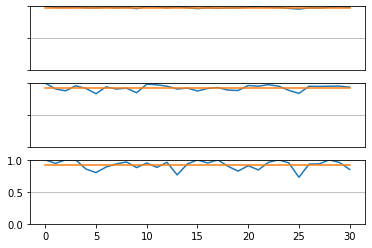

20:41:09.923712
#286 [Train: 0.059] [Test: 0.377] [Valid: 0.363]
#286 [Train: 0.981] [Test: 0.918] [Valid: 0.922]


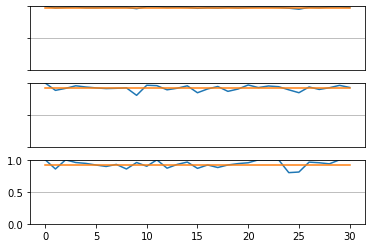

20:41:40.981023
#287 [Train: 0.058] [Test: 0.396] [Valid: 0.387]
#287 [Train: 0.982] [Test: 0.917] [Valid: 0.921]


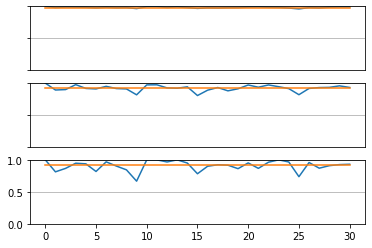

20:42:12.552286
#288 [Train: 0.059] [Test: 0.393] [Valid: 0.392]
#288 [Train: 0.981] [Test: 0.919] [Valid: 0.915]


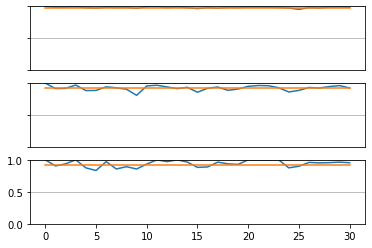

20:42:43.740720
#289 [Train: 0.060] [Test: 0.372] [Valid: 0.376]
#289 [Train: 0.981] [Test: 0.922] [Valid: 0.917]


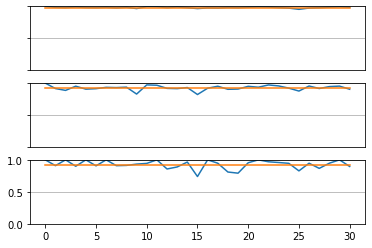

20:43:15.239340
#290 [Train: 0.058] [Test: 0.392] [Valid: 0.397]
#290 [Train: 0.981] [Test: 0.919] [Valid: 0.916]


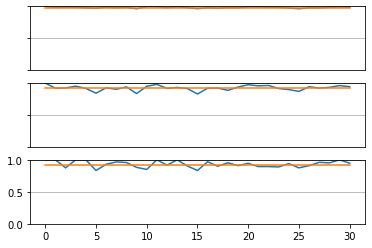

20:43:46.416162
#291 [Train: 0.055] [Test: 0.377] [Valid: 0.387]
#291 [Train: 0.983] [Test: 0.919] [Valid: 0.918]


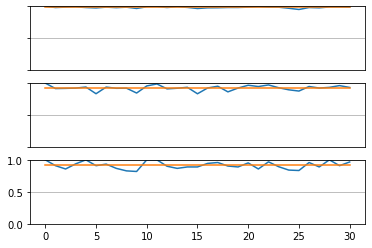

20:44:17.641651
#292 [Train: 0.055] [Test: 0.380] [Valid: 0.381]
#292 [Train: 0.983] [Test: 0.920] [Valid: 0.917]


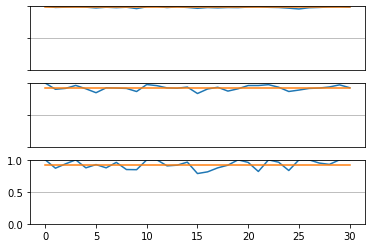

20:44:48.888578
#293 [Train: 0.057] [Test: 0.394] [Valid: 0.395]
#293 [Train: 0.982] [Test: 0.916] [Valid: 0.914]


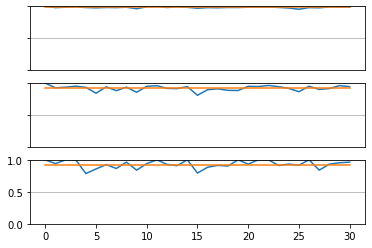

20:45:20.687162
#294 [Train: 0.054] [Test: 0.362] [Valid: 0.387]
#294 [Train: 0.983] [Test: 0.920] [Valid: 0.917]


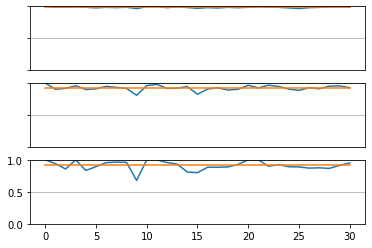

20:45:52.381221
#295 [Train: 0.057] [Test: 0.386] [Valid: 0.371]
#295 [Train: 0.982] [Test: 0.917] [Valid: 0.920]


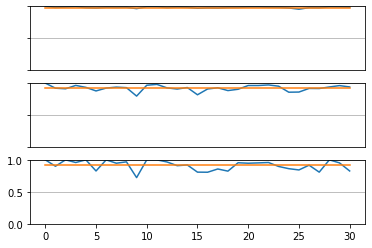

20:46:25.182458
#296 [Train: 0.057] [Test: 0.369] [Valid: 0.384]
#296 [Train: 0.982] [Test: 0.920] [Valid: 0.922]


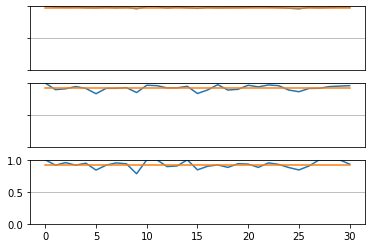

20:46:56.840363
#297 [Train: 0.055] [Test: 0.399] [Valid: 0.377]
#297 [Train: 0.982] [Test: 0.914] [Valid: 0.917]


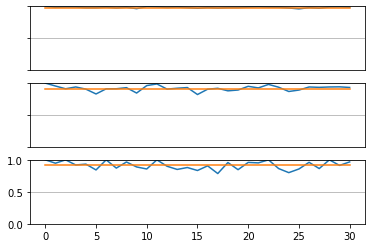

20:47:29.159713
#298 [Train: 0.052] [Test: 0.411] [Valid: 0.408]
#298 [Train: 0.984] [Test: 0.916] [Valid: 0.918]


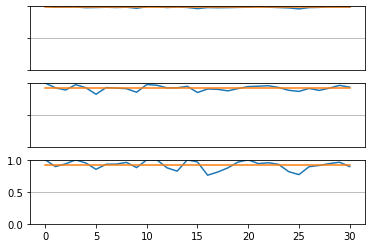

20:48:00.760892
#299 [Train: 0.056] [Test: 0.373] [Valid: 0.371]
#299 [Train: 0.982] [Test: 0.919] [Valid: 0.918]


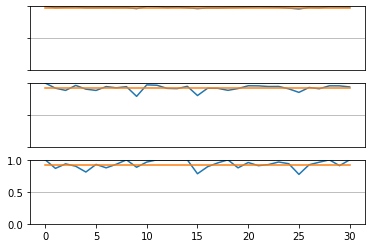

In [20]:
MAX_EPOCH = 300

writer = SummaryWriter(log_dir=run_name)

for epoch in range(MAX_EPOCH):
    training_loss_list = list()
    batch_generator = dataset_loader_training.batch_generator()
    model.train()
    
    correct_num = 0
    total_num = 0
    
    result_matrix_train = np.zeros([31, 2])
    result_matrix_train[0, :] = [1, 1]

    for (batch, label) in batch_generator:
        optimizer.zero_grad()
        pred = model(torch.cuda.FloatTensor(batch))
        loss = F.nll_loss(pred, torch.cuda.LongTensor(label))
        loss.backward()
        training_loss_list.append(loss.item())
        optimizer.step()
        
        _, pred_label = torch.max(pred, 1)
        correct_num += int((pred_label == torch.cuda.LongTensor(label)).sum().cpu().numpy())
        total_num += len(label)
        
        prediction_result = (pred_label == torch.cuda.LongTensor(label)).cpu().numpy()
        prediction_table = sorted(list(zip(prediction_result, label)), key = lambda x: x[1])
        
        for result, label in prediction_table:
            result_matrix_train[label, 0] += 1
            if result:
                result_matrix_train[label, 1] += 1
        
    acc_train = correct_num / total_num

    testing_loss_list = list()

    batch_generator = dataset_loader_testing.batch_generator()

    model.eval()
    
    correct_num = 0
    total_num = 0
    
    result_matrix_test = np.zeros([31, 2])
    result_matrix_test[0, :] = [1, 1]

    for (batch, label) in batch_generator:
    #     optimizer.zero_grad()
        pred = model(torch.cuda.FloatTensor(batch))
        loss = F.nll_loss(pred, torch.cuda.LongTensor(label).to(device))
#         loss.backward()
        testing_loss_list.append(loss.item())
    #     optimizer.step()
    
        _, pred_label = torch.max(pred, 1)
        correct_num += int((pred_label == torch.cuda.LongTensor(label)).sum().cpu().numpy())
        total_num += len(label)
        
        prediction_result = (pred_label == torch.cuda.LongTensor(label)).cpu().numpy()
        prediction_table = sorted(list(zip(prediction_result, label)), key = lambda x: x[1])
        
        for result, label in prediction_table:
            result_matrix_test[label, 0] += 1
            if result:
                result_matrix_test[label, 1] += 1
        
    acc_test = correct_num / total_num

    validation_loss_list = list()

    batch_generator = dataset_loader_validation.batch_generator()
    
    correct_num = 0
    total_num = 0
    
    result_matrix_eval = np.zeros([31, 2])
    result_matrix_eval[0, :] = [1, 1]

    for (batch, label) in batch_generator:
    #     optimizer.zero_grad()
        pred = model(torch.cuda.FloatTensor(batch))
        loss = F.nll_loss(pred, torch.cuda.LongTensor(label))
#         loss.backward()
        validation_loss_list.append(loss.item())
    #     optimizer.step()
    
        _, pred_label = torch.max(pred, 1)
        correct_num += int((pred_label == torch.cuda.LongTensor(label)).sum().cpu().numpy())
        total_num += len(label)
        
        for result, label in prediction_table:
            result_matrix_eval[label, 0] += 1
            if result:
                result_matrix_eval[label, 1] += 1
        
    acc_valid = correct_num / total_num
    
    training_loss_mean = np.mean(training_loss_list)
    testing_loss_mean = np.mean(testing_loss_list)
    validation_loss_mean = np.mean(validation_loss_list)
    
    print(datetime.datetime.now().time())
    print('#{:03d} [Train: {:0.3f}] [Test: {:0.3f}] [Valid: {:0.3f}]'.format(epoch, training_loss_mean, testing_loss_mean, validation_loss_mean))
    print('#{:03d} [Train: {:0.3f}] [Test: {:0.3f}] [Valid: {:0.3f}]'.format(epoch, acc_train, acc_test, acc_valid))
    
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)
    axes[0].plot(result_matrix_train[:, 1] / result_matrix_train[:, 0])
    axes[0].plot(np.ones(len(result_matrix_train)) * acc_train)
    axes[0].tick_params(bottom=False, top=False, labelbottom=False, right=False, labelleft=False)
    axes[0].set_ylim([0, 1])
    axes[0].yaxis.grid(True)
                 
    axes[1].plot(result_matrix_test[:, 1] / result_matrix_test[:, 0])
    axes[1].plot(np.ones(len(result_matrix_test)) * acc_test)
    axes[1].tick_params(bottom=False, top=False, labelbottom=False, right=False, labelleft=False)
    axes[1].set_ylim([0, 1])
    axes[1].yaxis.grid(True)
                 
    axes[2].plot(result_matrix_eval[:, 1] / result_matrix_eval[:, 0])
    axes[2].plot(np.ones(len(result_matrix_eval)) * acc_valid)
    axes[2].set_ylim([0, 1])
    axes[2].yaxis.grid(True)
    plt.show()
    
    writer.add_scalar('Loss/Train', training_loss_mean, epoch)
    writer.add_scalar('Loss/Test', testing_loss_mean, epoch)
    writer.add_scalar('Loss/Valid', validation_loss_mean, epoch)
    writer.add_scalar('Acc/Train', acc_train, epoch)
    writer.add_scalar('Acc/Test', acc_test, epoch)
    writer.add_scalar('Acc/Valid', acc_valid, epoch)
    

In [21]:
# output = model(torch.cuda.FloatTensor(batch))

In [22]:
# output.shape

In [23]:
# torch.tensor(batch).unsqueeze_(1).shape

In [24]:
# input_tensor = torch.tensor(batch).to(device).float()
# input_tensor = input_tensor.transpose(1, 2)
# model(input_tensor).shape

In [25]:
# for batch, label_list in batch_generator:
#     print(batch.shape[0])
#     plt.figure(figsize=(5, 1))
#     plt.plot(label_list)
#     plt.show()
    
#     plt.figure(figsize=(6, 18))
# #     plt.imshow(batch[0], aspect='auto')
#     plt.imshow(batch[0])
#     plt.show()
    
#     break